# Audio classification

Problema 1 - Audio MNIST

## Descripción

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

## Dataset
https://www.tensorflow.org/datasets/catalog/spoken_digit


El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor. Pronunciaciones en inglés.

Un conjunto de datos de audio/voz simple que consta de grabaciones de dígitos hablados en archivos wav a 8 kHz. Las grabaciones se recortan para que tengan un silencio casi mínimo al principio y al final.

Los archivos se nombran en el siguiente formato: {digitLabel}{speakerName}{index}.wav

## Objetivo
Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

- Modelo convolucional sobre los espectrogramas de los clips.
- Modelo recurrente sobre los espectrogramas de los clips.


Se comienza por importar el set de datos y las librerías necesarias

In [109]:
import os
import pathlib

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_io as tfio
from IPython import display
from IPython.display import Audio
from pydub import AudioSegment
from scipy.signal import spectrogram
import shutil
import audiomentations
from audiomentations import AddGaussianNoise, PitchShift
from tensorflow.keras.callbacks import ModelCheckpoint

os.makedirs('checkpoints/char_model/models_audio_classification', exist_ok=True)

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Se descarga y descomprime el dataset

In [1]:
!wget https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.9.tar.gz
!tar -xzf v1.0.9.tar.gz

--2024-06-25 15:24:11--  https://github.com/Jakobovski/free-spoken-digit-dataset/archive/v1.0.9.tar.gz
Resolving github.com (github.com)... 

20.201.28.151
Connecting to github.com (github.com)|20.201.28.151|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/tar.gz/refs/tags/v1.0.9 [following]
--2024-06-25 15:24:12--  https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/tar.gz/refs/tags/v1.0.9
Resolving codeload.github.com (codeload.github.com)... 20.201.28.149
Connecting to codeload.github.com (codeload.github.com)|20.201.28.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.0.9.tar.gz’

v1.0.9.tar.gz           [<=>                 ]  11.42M  1.58MB/s    in 6.7s    

2024-06-25 15:24:19 (1.69 MB/s) - ‘v1.0.9.tar.gz’ saved [11975353]



Establecer GPU por defecto en caso de estar disponible

In [4]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## 1 - Análisis Exploratorio (EDA)

Se comenzará haciendo un análisis explotarorio del dataset para conocer sus características principales y evaluar si es necesario hacer algún proceso antes de comenzar.

### 1.1 Distribución de clases
Primero, se busca entender la distribución de los dígitos en el conjunto de datos. Se contará cuántos archivos hay para cada dígito (0-9).

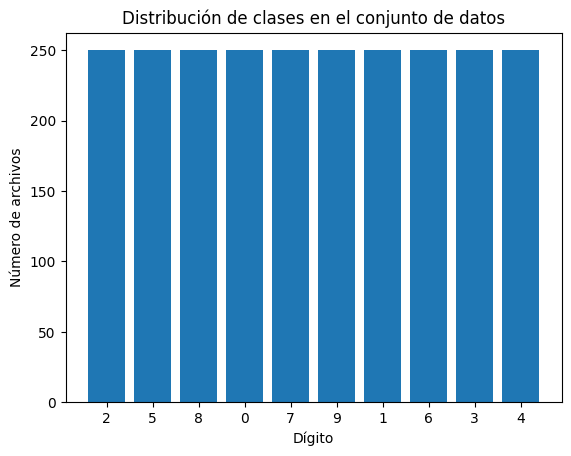

In [5]:
# Directorio donde se encuentran los archivos de audio
data_dir = 'free-spoken-digit-dataset-1.0.9/recordings'

# Obtener la distribución de clases
file_names = os.listdir(data_dir)
digit_labels = [file_name.split('_')[0] for file_name in file_names]
class_counts = Counter(digit_labels)

# Graficar la distribución de clases
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Dígito')
plt.ylabel('Número de archivos')
plt.title('Distribución de clases en el conjunto de datos')
plt.show()

Se observa que existe el mismo número de muestras de audio para cada dígito

### 1.2 Duración de los archivos de audio
Se observará la duración de los archivos de audio para entender la variabilidad y consistencia de las muestras.

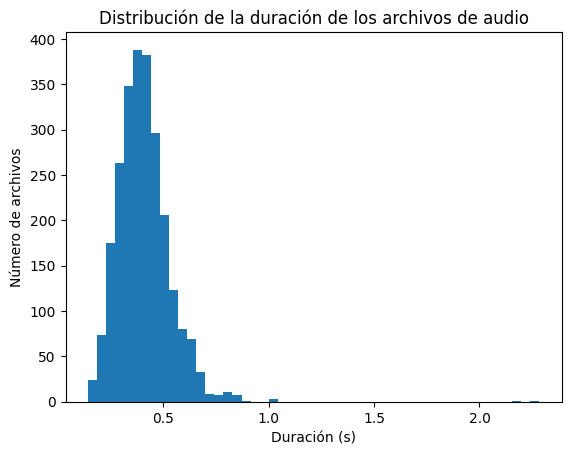

Duración mínima registrada: 0.144 segundos
Duración máxima registrada: 2.283 segundos


In [6]:
# Calcular la duración de cada archivo de audio
durations = []
for file_name in file_names:
    file_path = os.path.join(data_dir, file_name)
    audio = AudioSegment.from_file(file_path)
    durations.append(len(audio) / 1000.0)  # Duración en segundos

# Graficar la distribución de la duración de los archivos de audio
plt.hist(durations, bins=50)
plt.xlabel('Duración (s)')
plt.ylabel('Número de archivos')
plt.title('Distribución de la duración de los archivos de audio')
plt.show()

# Obtener la duración mínima y máxima registrada
min_duration = min(durations)
max_duration = max(durations)

print("Duración mínima registrada:", min_duration, "segundos")
print("Duración máxima registrada:", max_duration, "segundos")


En su mayoría, los archivos de audio tienen una duración menor a 1 segundo.

### 1.3 Verificación de consistencia de formatos
Se asegurará de que todos los archivos de audio tienen una frecuencia de muestreo y número de canales consistentes.

In [7]:
# Verificar la frecuencia de muestreo y número de canales
sample_rates = []
num_channels = []

for file_name in file_names:
    file_path = os.path.join(data_dir, file_name)
    audio = AudioSegment.from_file(file_path)
    sample_rates.append(audio.frame_rate)
    num_channels.append(audio.channels)

print(f'Frecuencias de muestreo únicas: {set(sample_rates)}')
print(f'Número de canales únicos: {set(num_channels)}')


Frecuencias de muestreo únicas: {8000}
Número de canales únicos: {1}


Se encuentra que, tanto las frecuencias como los canales en las muestras son únicos.

### 1.4 Verificación de la calidad del audio
Se reproducirán algunos archivos de audio y se verificará si hay ruido o clips corruptos.

In [8]:
from IPython.display import Audio, display
from pydub import AudioSegment
import io

# Función para reproducir un archivo de audio
def play_audio(file_path):
    audio = AudioSegment.from_file(file_path)
    audio_bytes = io.BytesIO()
    audio.export(audio_bytes, format='wav')
    audio_bytes.seek(0)
    return Audio(audio_bytes.read(), rate=audio.frame_rate)

# Reproducir ejemplos de audio
for digit in range(10):
    example_files = [f for f in file_names if f.startswith(str(digit))]
    if example_files:
        file_path = os.path.join(data_dir, example_files[0])
        print(f'Reproduciendo: {example_files[0]}')
        display(play_audio(file_path))


Reproduciendo: 0_george_1.wav


Reproduciendo: 1_george_17.wav


Reproduciendo: 2_jackson_25.wav


Reproduciendo: 3_theo_49.wav


Reproduciendo: 4_george_28.wav


Reproduciendo: 5_nicolas_11.wav


Reproduciendo: 6_george_5.wav


Reproduciendo: 7_jackson_13.wav


Reproduciendo: 8_jackson_35.wav


Reproduciendo: 9_nicolas_14.wav


Luego de oir un clip de audio de ejemplo para cada dígito y habiendo en ellos locutores diferentes, se observa que independientemente del dígito y locutor, los audios poseen un sonido nítido, sin presencia de ruido detectable. Se intuye, que estas obsevaciones se pueden extender al resto de las muestras.

### 1.5 Visualización de la forma de onda

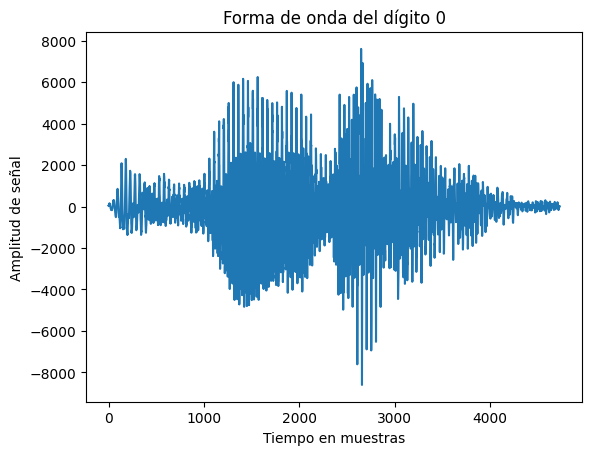

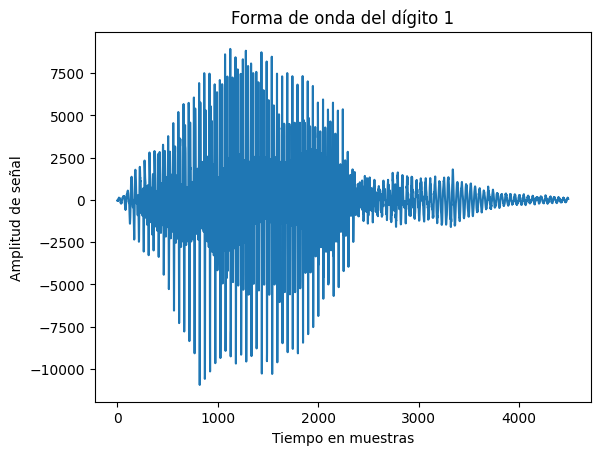

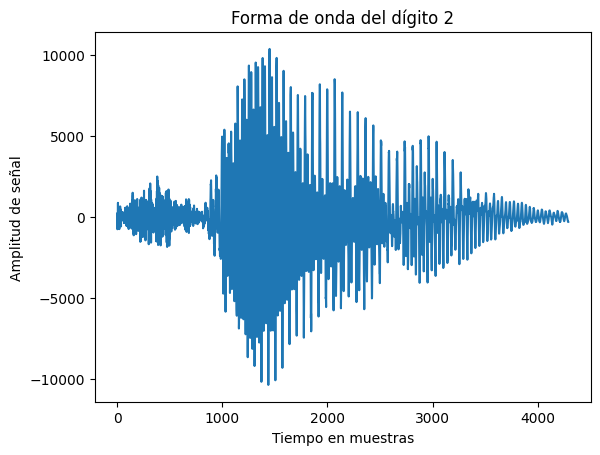

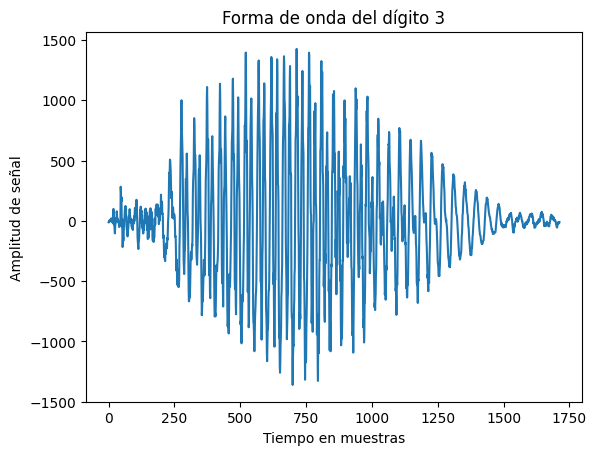

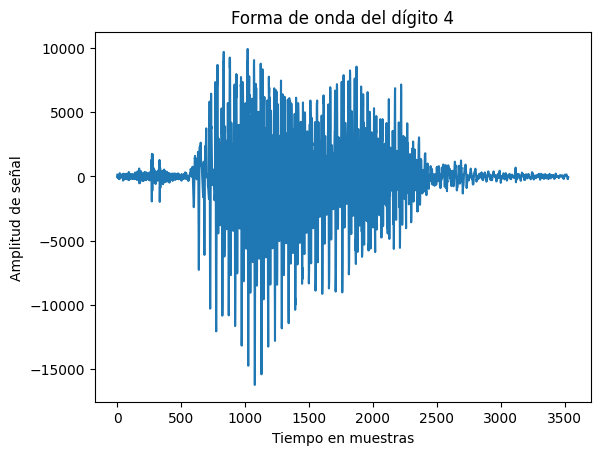

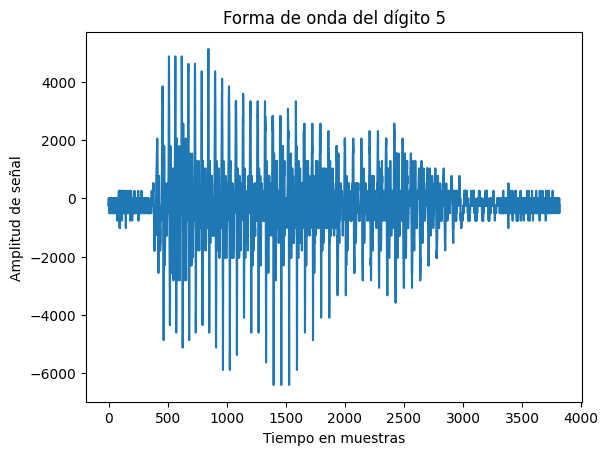

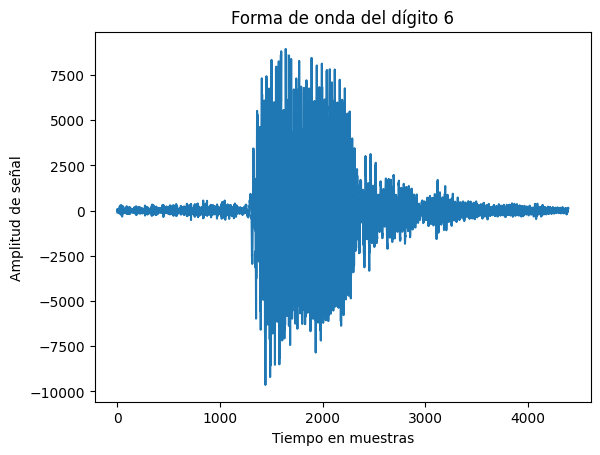

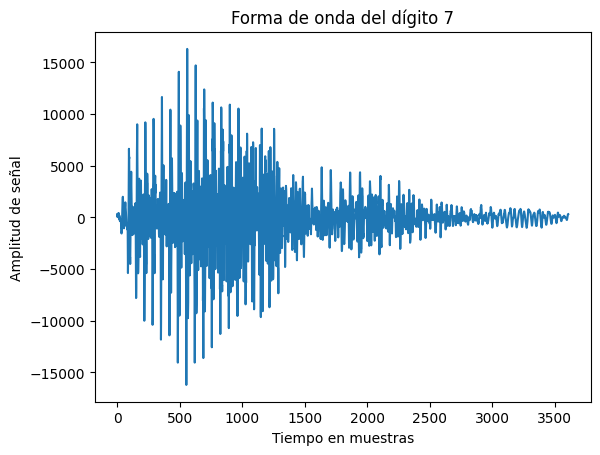

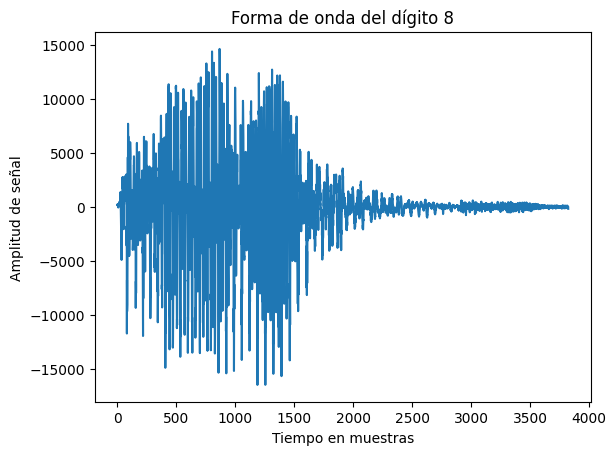

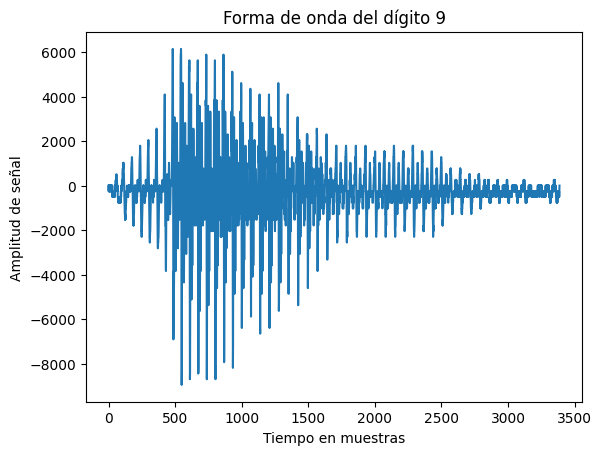

In [17]:
# Visualizar espectrogramas de ejemplo
for digit in range(10):
    example_files = [f for f in file_names if f.startswith(str(digit))]
    if example_files:
        file_path = os.path.join(data_dir, example_files[0])
        audio = AudioSegment.from_file(file_path)
        samples = np.array(audio.get_array_of_samples()) 
        # Generar espectrograma
        plt.plot(samples)
        plt.ylabel('Amplitud de señal')
        plt.xlabel('Tiempo en muestras')
        plt.title(f'Forma de onda del dígito {digit}')
        plt.show()

Observaciones generales:

- Las señales tienen una variabilidad significativa en la amplitud, indicando cambios de volumen a lo largo del tiempo.

- En algunos casos, hay una mayor densidad de picos al inicio de la señal, que luego disminuye gradualmente. Esto puede sugerir la pronunciación de un dígito que comienza con un sonido fuerte y se desvanece. En otros casos, hay una mayor densidad de picos en el centro de la señal, indicando la dicción de dígitos que comienzan con sonidos más apagados, luego son más fuertes y finalemte se desvanece.

- Casi todos los audios tienen una cantidad de muestras menor a 4000. Esto se condice con lo observado en la exploración anterior en la que se halló que la mayoría de ellos no lcanzan el segundo de duración.

- Hay picos muy pequeños dispersos a lo largo de la señal, pudiendo indicar la presencia de ruido. Sin embargo, su amplitud es muy gercana a 0, lo que puede explicar que no se perciba facilmente al momento de oírlos.

### 1.6 Visualización de espectrogramas
Se usa scipy y matplotlib para esta tarea.

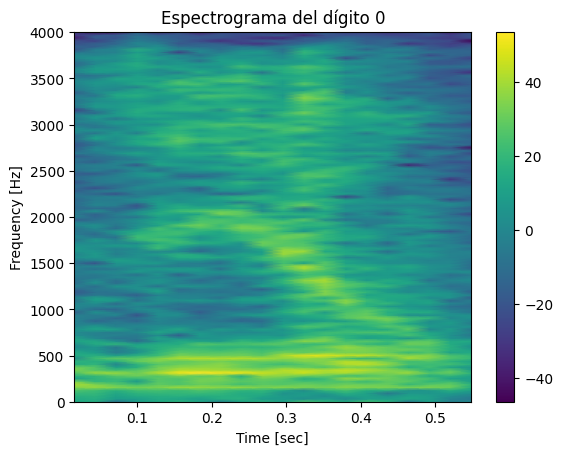

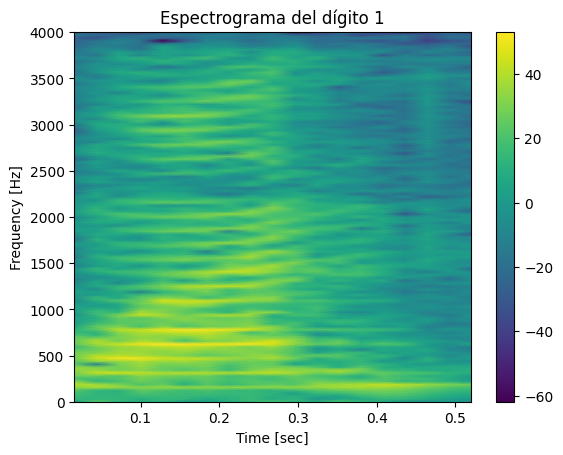

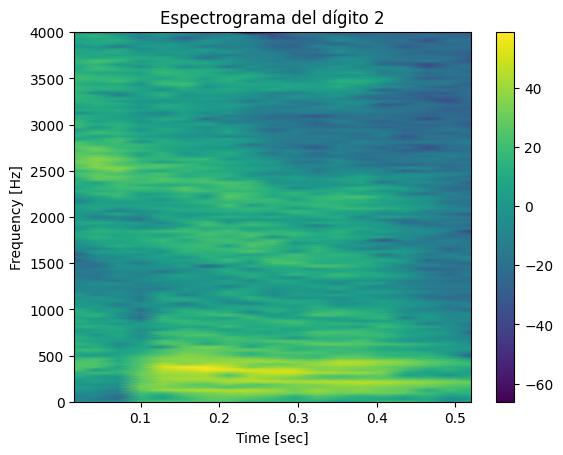

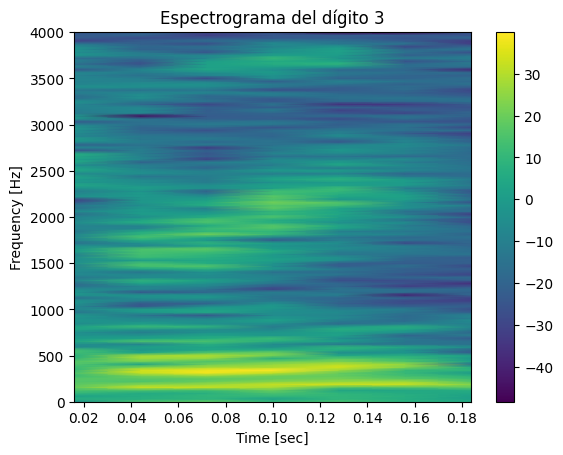

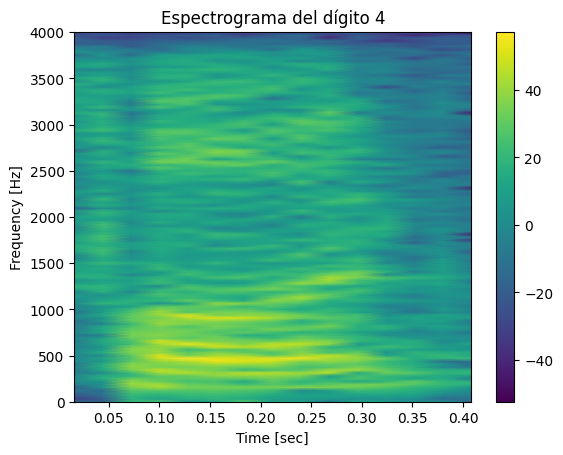

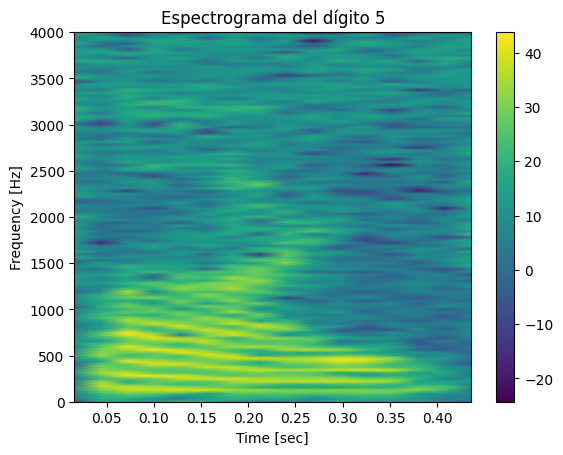

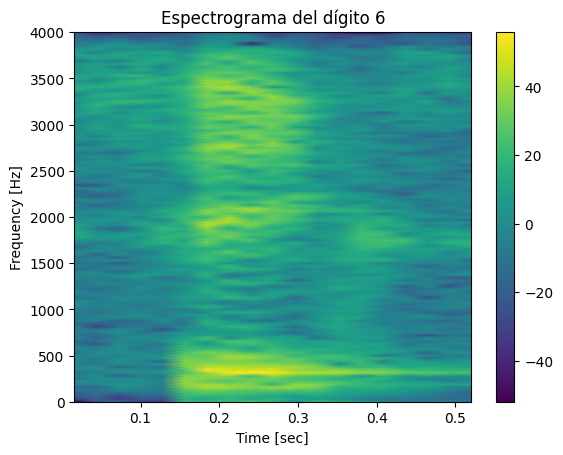

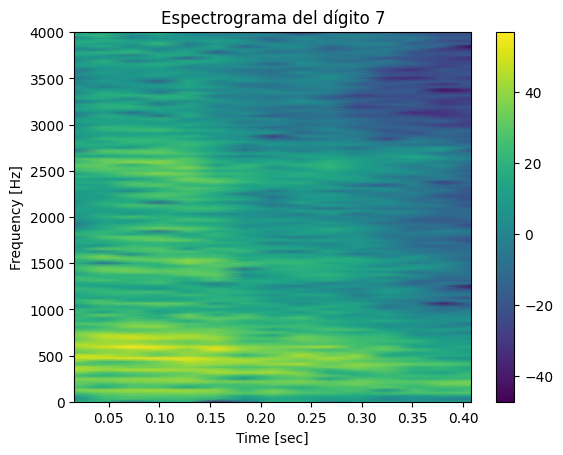

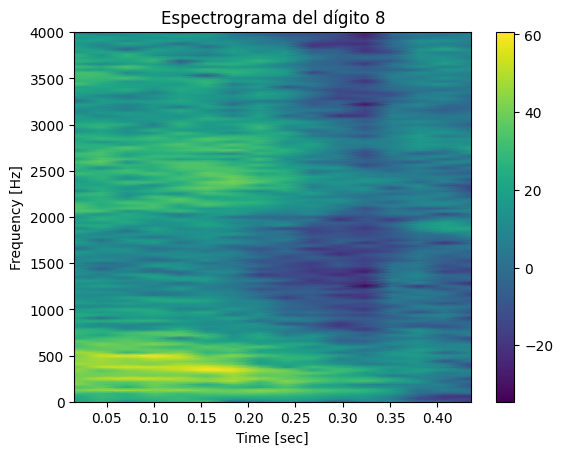

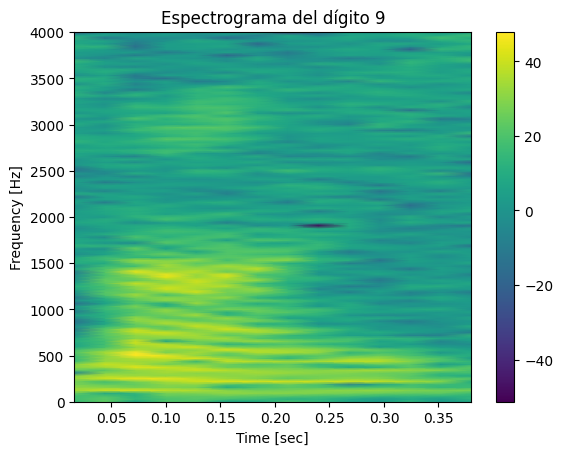

In [16]:
# Visualizar espectrogramas de ejemplo
for digit in range(10):
    example_files = [f for f in file_names if f.startswith(str(digit))]
    if example_files:
        file_path = os.path.join(data_dir, example_files[0])
        audio = AudioSegment.from_file(file_path)
        samples = np.array(audio.get_array_of_samples())
        
        # Generar espectrograma
        f, t, Sxx = spectrogram(samples, audio.frame_rate)
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(f'Espectrograma del dígito {digit}')
        plt.colorbar()
        plt.show()


Coloración:

- Escala de colores: La intensidad del color representa la amplitud de las frecuencias. Los colores más claros (amarillo) indican una mayor intensidad, mientras que los colores más oscuros (azul/violeta) indican una menor intensidad.

- Interpretación de colores: Las bandas amarillas indican que en esos momentos y frecuencias específicas, la energía del sonido es alta. En contraste, las áreas azules/violetas representan frecuencias con baja energía.

Observaciones específicas:

- Los patrones de frecuencias son distintivos para cada dígito, lo que ayuda en la clasificación. Por ejemplo, el dígito 6 puede tener una combinación específica de frecuencias bajas, medias y altas que lo diferencian de otros dígitos.
    La duración del sonido y cómo se distribuye la energía en el tiempo también son características importantes que permiten diferenciar el espectrograma de un dígito del otro.

## 2 - Separación en conjuntos de entrenamiento, validación y prueba

En este código, train_ds, val_ds y test_ds son datasets de TensorFlow que contienen los archivos de audio divididos en conjuntos de entrenamiento, validación y prueba. Cada elemento del dataset consiste en un par (audio, etiqueta), donde audio es el audio decodificado y etiqueta es el label correspondiente al archivo de audio.

### 2.1 Reorganizar las muestras de audio en distintas carpetas

Se reorgnizarán los archivos de audio para que una porción mayoritaria se encuentre dentro de la carpeta de entrenamiento y la otra restante dentro de la carpeta de test. A su vez, en el interior de cada uno de estos directorios, los audios estarán divididos en carpetas de acuerdo con su etiqueta, es decir, los audios de dígito cero estarán dentro del directorio "0" y así sucesivamente.

In [245]:
# Directorio donde se encuentran los archivos de audio
data_dir = 'free-spoken-digit-dataset-1.0.9/recordings'
new_audio_dir = 'free-spoken-digit-dataset-1.0.9/recordings/train_validation_set'

In [18]:
# Crear directorios para cada dígito (0-9) si no existen
for digit in range(10):
    digit_dir = os.path.join(new_audio_dir, str(digit))
    if not os.path.exists(digit_dir):
        os.makedirs(digit_dir)

# Obtener la lista de archivos de audio
file_names = os.listdir(data_dir)
file_names = [f for f in file_names if f.endswith('.wav')]

# Mover los archivos a las carpetas correspondientes
for file_name in file_names:
    digit = file_name.split('_')[0]
    src_path = os.path.join(data_dir, file_name)
    dst_path = os.path.join(new_audio_dir, digit, file_name)
    shutil.move(src_path, dst_path)

print("Archivos movidos a carpetas correspondientes por dígito.")


Archivos movidos a carpetas correspondientes por dígito.


Se separa una porción de los datos para el conjunto de prueba y luego se cargan los conjuntos de entrenamiento, validación y prueba

In [19]:
# Mover archivos a una carpeta de prueba separada 
test_ratio = 0.2  # Porcentaje de archivos a mover a la carpeta de prueba

for digit in range(10):
    digit_dir = os.path.join(new_audio_dir, str(digit))
    test_digit_dir = os.path.join('free-spoken-digit-dataset-1.0.9/recordings/test_set', str(digit))
    if not os.path.exists(test_digit_dir):
        os.makedirs(test_digit_dir)
    
    files = os.listdir(digit_dir)
    np.random.shuffle(files)
    num_test_files = int(len(files) * test_ratio)
    
    test_files = files[:num_test_files]
    
    for file in test_files:
        src_path = os.path.join(digit_dir, file)
        dst_path = os.path.join(test_digit_dir, file)
        shutil.move(src_path, dst_path)


Cargar los conjuntos de entrenamiento, validación y prueba

In [246]:
# Crear datasets de entrenamiento y validación a partir del directorio
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=new_audio_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=8000,
    subset='both',
)

# Crear un dataset de prueba separado
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='free-spoken-digit-dataset-1.0.9/recordings/test_set',
    batch_size=64,
    seed=0,
    output_sequence_length=8000,
    shuffle=False
)

Found 2000 files belonging to 10 classes.
Using 1600 files for training.
Using 400 files for validation.
Found 500 files belonging to 10 classes.


Se observan los labels presentes en el set de entrenamiento

In [247]:
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


label names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Se observan las especificaciones de las muestras del set de entrenamiento

In [248]:
train_ds.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### 2.2 Data augmentation

Con el fin de aportar mayor volumen y variedad al set de datos de entrenamiento, para obtener una mayor robustez en el modelo al momento de inferir sobre nuevos datos, se realiza data augmentation en el set de entrenamiento.

Funciones de augmentación

AddGaussianNoise: Añade ruido gaussiano a las muestras.

PitchShift: cambia el sonido hacia arriba o hacia abajo sin cambiar el tempo. Puede degradar la calidad del audio al "difuminar" los sonidos transitorios, alterar el timbre de los sonidos armónicos y distorsionar las modulaciones de tono. Esto puede resultar en una pérdida de nitidez, claridad o naturalidad en el audio transformado.

In [249]:
# Función para añadir ruido
transform_noise = AddGaussianNoise(
    min_amplitude=0.001,
    max_amplitude=0.018,
    p=1.0
)

def add_noise(audio):
    augmented_audio_np = transform_noise(audio, sample_rate=8000)
    augmented_audio_tensor = tf.convert_to_tensor(augmented_audio_np)
    return augmented_audio_tensor

# Funciones de aumento de datos para el dataset
def augment_data_noise(audio, label):
    augmented_audio = tf.py_function(add_noise, [audio], tf.float32)
    augmented_audio.set_shape(audio.shape)
    return (augmented_audio, label)

# Función para augmentar el dataset
def augment_dataset(ds):
    augmented_ds1 = ds.map(augment_data_noise, num_parallel_calls=tf.data.AUTOTUNE)
    
    concatenated_ds = ds.concatenate(augmented_ds1)
    
    return concatenated_ds

train_ds_with_augmentation = augment_dataset(train_ds)

Se observan las especificaciones de las muestras del set de entrenamiento

In [250]:
train_ds_with_augmentation.element_spec

(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Las especificaciones continuan siendo las mismas

Se observa la cantidad de datos presente en el set de entrenamiento, validación y prueba luego de realizar augmentation de datos

In [251]:
# Contar el número total de datos en cada conjunto
num_train = sum(1 for _ in train_ds.unbatch())
num_new_train = sum(1 for _ in train_ds_with_augmentation.unbatch())
num_val = sum(1 for _ in val_ds.unbatch())
num_test = sum(1 for _ in test_ds.unbatch())

print(f'Total de datos de entrenamiento sin augmentation: {num_train}')
print(f'Total de datos de entrenamiento con augmentation: {num_new_train}')
print(f'Total de datos de validación: {num_val}')
print(f'Total de datos de prueba: {num_test}')


2024-07-01 21:52:17.790800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-01 21:52:20.652460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-01 21:52:21.125170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total de datos de entrenamiento sin augmentation: 1600
Total de datos de entrenamiento con augmentation: 3200
Total de datos de validación: 400
Total de datos de prueba: 500


2024-07-01 21:52:21.808091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Anteriormente, se contaba con 1600 datos de entrenamiento. Posterior a la realización de data augmentation, se cuenta con 3200. Se ha incrementado al doble el número de muestras para entrenar el modelo.

El dataset contiene un solo canal de audio por clip, se usara tf.squeeze para descartar el eje extra.

In [252]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds_with_augmentation = train_ds_with_augmentation.map(squeeze, tf.data.AUTOTUNE)
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Se imprime el shape para el set de datos con y sin augmentation

In [253]:
for example_audio_aug, example_labels_aug in train_ds_with_augmentation.take(1):
  print(f'Shape de un batch de audios de ejemplo para etrenamiento con augmentation {example_audio_aug.shape}')
  print(f'Shape de un batch de labels de ejemplo para etrenamiento con augmentation {example_labels_aug.shape}')
  
for example_audio, example_labels in train_ds.take(1):
  print(f'Shape de un batch de audios de ejemplo para etrenamiento sin augmentation {example_audio.shape}')
  print(f'Shape de un batch de labels de ejemplo para etrenamiento sin augmentation {example_labels.shape}')

Shape de un batch de audios de ejemplo para etrenamiento con augmentation (64, 8000)
Shape de un batch de labels de ejemplo para etrenamiento con augmentation (64,)


2024-07-01 21:52:25.931619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Shape de un batch de audios de ejemplo para etrenamiento sin augmentation (64, 8000)
Shape de un batch de labels de ejemplo para etrenamiento sin augmentation (64,)


2024-07-01 21:52:26.233425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Se define una funcón para obtener los gráficos de espectrogrma de los audios

In [254]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=128, frame_step=105)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Se muestran características y se escuchan algunos audios de ejemplo, cuya duración es ahora de 1 segundo

In [255]:
for i in range(3):
  label = label_names[example_labels_aug[i]]
  waveform = example_audio_aug[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

Label: 8
Waveform shape: (8000,)
Spectrogram shape: (75, 65, 1)
Audio playback


Label: 8
Waveform shape: (8000,)
Spectrogram shape: (75, 65, 1)
Audio playback


Label: 2
Waveform shape: (8000,)
Spectrogram shape: (75, 65, 1)
Audio playback


## 3 - Creación de espectrogramas

Con el fin de poder obtener un tipo de dato que pueda ser input de las redes neuronales, tales como CNN y RNN, se obtendrán los espectrogramas correspondientes a las muestras de audio y así, los mismos, ya convertidos a un tipo de dato equivalente a una imagen, pasarán a ser el set de datos con el que se alimentarán los modelos.

Definimos una función para mostrar el espectrograma:

In [256]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec) 

Ploteamos formas de onda y sus respectivos espectrogramas.

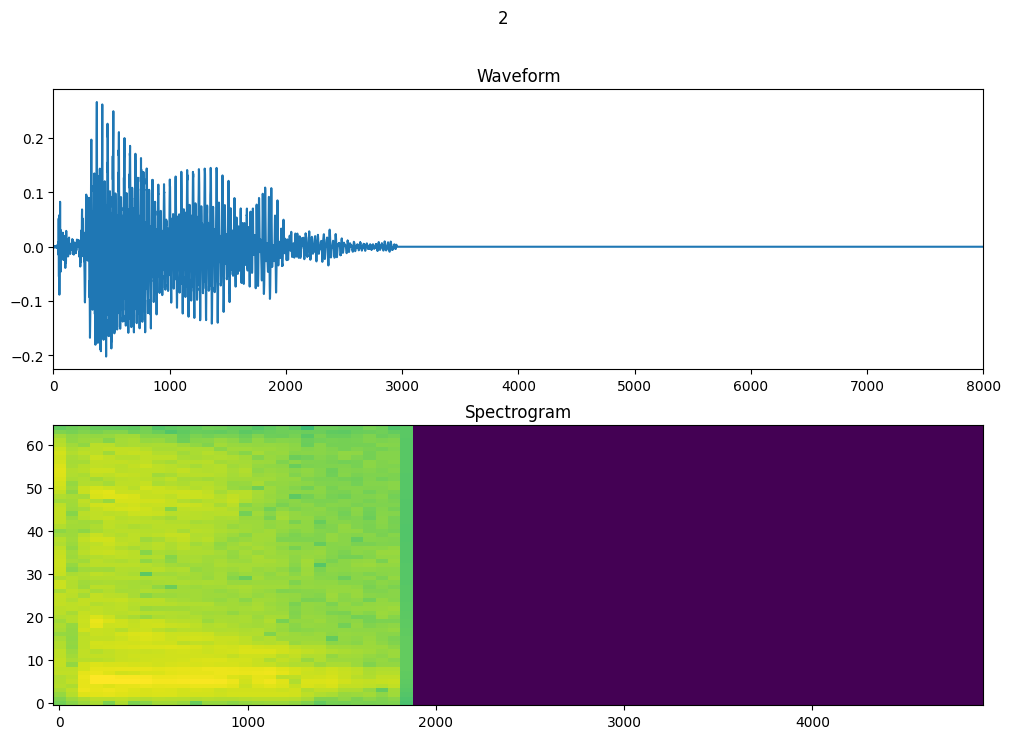

In [257]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 8000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Se obseva que el sonido se encuentra concentrado al inicio del espectrograma y luego, se completa el segundo de audio coon silencio.

Ahora se crea un dataset de espectrogramas utilizando la función definida.

In [258]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

Se aplica la función para obtener los espectrogramas al set de entrenamiento y validación

In [259]:
train_spectrogram_ds_with_augmentation = make_spec_ds(train_ds_with_augmentation)

In [260]:
for audio_aug, labels_aug in train_spectrogram_ds_with_augmentation.take(1):
  print(f'Shape de un batch de audios de ejemplo para etrenamiento con augmentation {audio_aug.shape}')
  print(f'Shape de un batch de labels de ejemplo para etrenamiento con augmentation {labels_aug.shape}')

Shape de un batch de audios de ejemplo para etrenamiento con augmentation (64, 75, 65, 1)
Shape de un batch de labels de ejemplo para etrenamiento con augmentation (64,)


2024-07-01 21:52:47.058161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [261]:
train_spec_without_aug = make_spec_ds(train_ds)

In [262]:
val_spectrogram_ds = make_spec_ds(val_ds)

Examinar el espectrograma para distintos ejemplos del dataset.

- Ejemplos del dataset con augmentation

In [263]:
for example_spectrograms_aug, example_spect_labels_aug in train_spectrogram_ds_with_augmentation.take(1):
  break

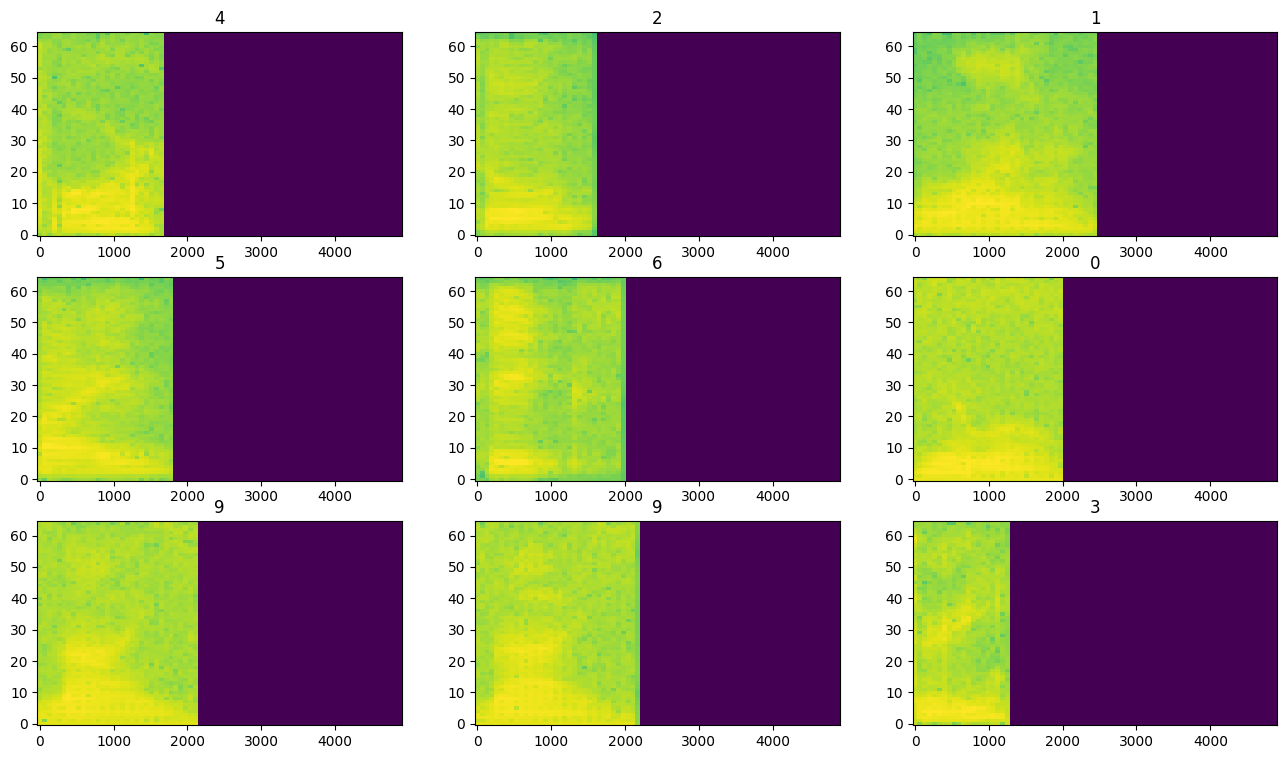

In [264]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.set_title(label_names[example_spect_labels_aug[i].numpy()])
    plot_spectrogram(example_spectrograms_aug[i].numpy(), ax)
    

plt.show()

- Ejemplos del dataset sin augmentation

In [265]:
for example_spectrograms, example_spect_labels in train_spec_without_aug.take(1):
  break

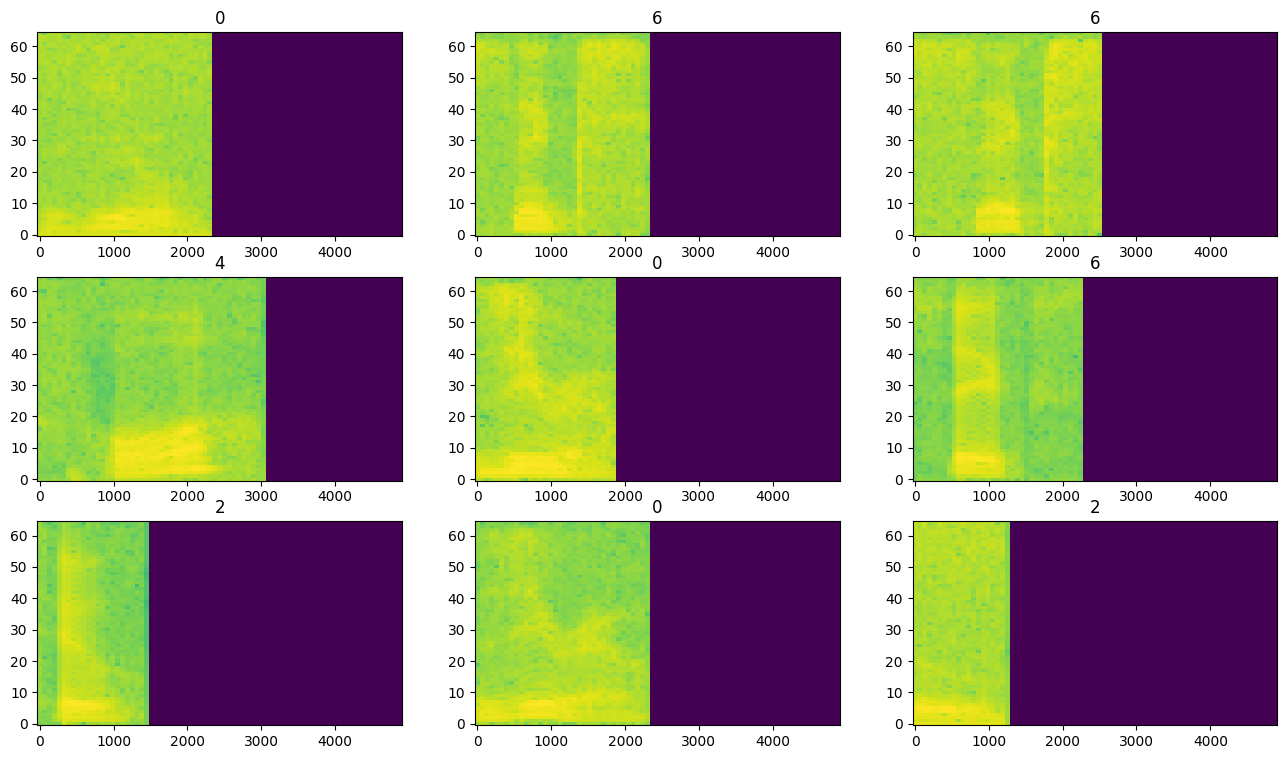

In [266]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.set_title(label_names[example_spect_labels[i].numpy()])
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    

plt.show()

En ambos casos, la duración de los audios debe completarse con silencios y es al inicio donde se presenta energía de sonido altas. Es decir, que aproximadamente la mitad del espectrograma es lo que le será de mayor utilidad a las redes neuronales para clasificar los audios en dígitos.

## 4 - Modelos de clasificación

### 4.1 Modelo de clasificación con redes neuronales convolucionales

Para el modelo, se utilizará una red neuronal convolucional simple (CNN), ya que se han transformado los archivos de audio en imágenes de espectrograma.

El modelo tf.keras.Sequential utilizará las siguientes capas de preprocesamiento de Keras:

- tf.keras.layers.Resizing: para reducir la resolución de la entrada y permitir que el modelo entrene más rápido.

- tf.keras.layers.Normalization: para normalizar cada píxel en la imagen basándose en su media y desviación estándar.

    Para la capa de Normalización, primero se debe llamar a su método adapt en los datos de entrenamiento para calcular las estadísticas agregadas (es decir, la media y la desviación estándar).

- layers.Conv2D(32, 3, activation='relu'): Aplica una capa Conv2D a cada ventana de la secuencia.

Optimizamos la carga del dataset

In [267]:
# Set de datos de entrenamiento con augmentation
train_spectrogram_ds_with_augmentation = train_spectrogram_ds_with_augmentation.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
# Set de datos de entrenamiento sin augmentation
train_spec_without_aug = train_spec_without_aug.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
# Set de validación
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Se realiza un shuffle de los sets de entrenamiento para que el modelo no aprenda a tender a predecir una clase sin considerar las demás.

#### 4.1.1 Modelo de CNN para entrenamiento con set de datos con augmentation

In [140]:
input_shape = example_spectrograms_aug.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds_with_augmentation.map(map_func=lambda spec, label: spec))

model_cnn_with_augmentation = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model_cnn_with_augmentation.summary()

Input shape: (75, 65, 1)


2024-07-01 19:49:28.924655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [26]:
# Compilar el modelo
model_cnn_with_augmentation.compile(
    optimizer='adam',  # Optimizador Adam
    loss='sparse_categorical_crossentropy',  # Función de pérdida categorical_crossentropy
    metrics=['accuracy']  # Métrica de evaluación: precisión (accuracy)
)

Entrenamos durante 50 epochs con early stopping:

In [27]:
# Set up checkpointing
char_checkpoint = ModelCheckpoint(
    'checkpoints/models_audio_classification/model_cnn_aug/model_cnn_aug.{epoch:02d}-{val_loss:.2f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_weights_only=True,
    verbose=1
)

In [29]:
EPOCHS = 50
history = model_cnn_with_augmentation.fit(
    train_spectrogram_ds_with_augmentation,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),char_checkpoint]
)

Epoch 1/50


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.2863 - loss: 1.9470
Epoch 1: val_loss improved from inf to 1.14681, saving model to checkpoints/char_model/models_audio_classification/model_cnn_aug/model_cnn_aug.01-1.15.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.2886 - loss: 1.9419 - val_accuracy: 0.6350 - val_loss: 1.1468
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6165 - loss: 1.1646
Epoch 2: val_loss improved from 1.14681 to 0.73592, saving model to checkpoints/char_model/models_audio_classification/model_cnn_aug/model_cnn_aug.02-0.74.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.6169 - loss: 1.1632 - val_accuracy: 0.8350 - val_loss: 0.7359
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7376 - loss: 0.8084
Epoch 3: val_loss improved from 0.73592 to 0.52367, saving model to checkpoints/char_model/models_audio_classification/model_cnn_aug/model_cnn_aug.03-0.52.weights.h5
50/50 ━━━━━━━━━━━━━━━━━

El modelo alcanza prontamente, en la época 4 de entrenamiento, un accuracy elevado.

Se grafican los resultados

Text(0, 0.5, 'Accuracy [%]')

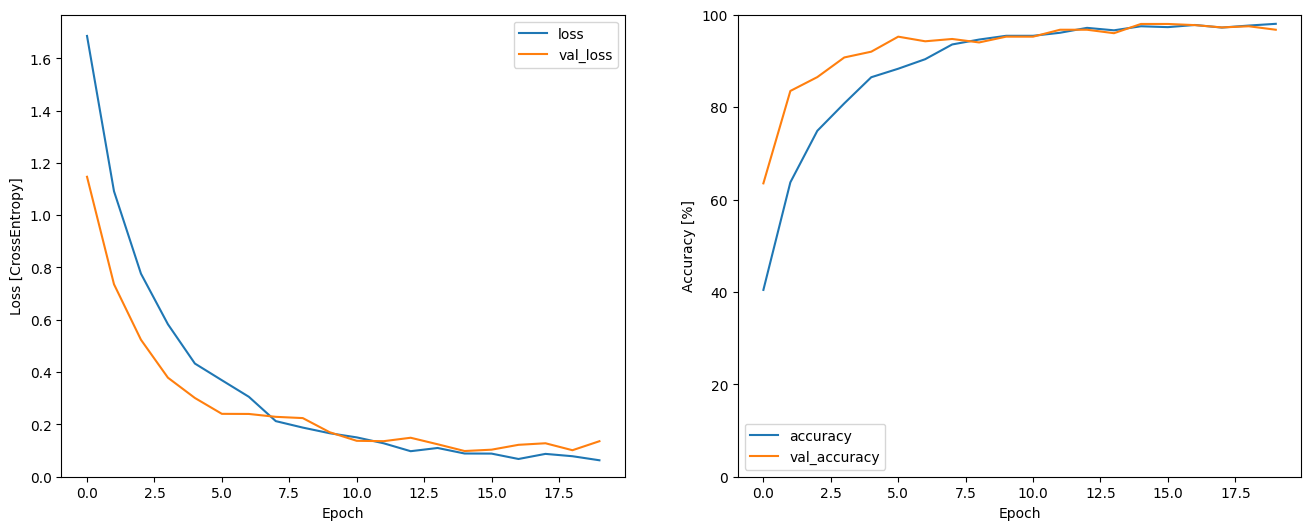

In [30]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

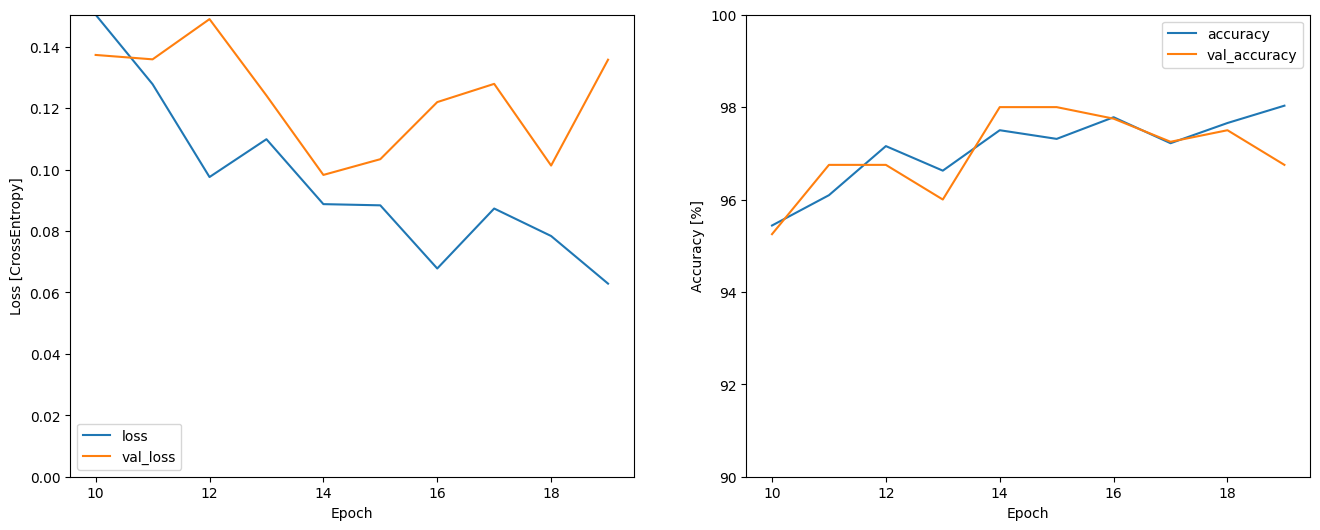

In [31]:
# Definir la época desde la que empezar a graficar
start_epoch = 10

# Filtrar los datos a partir de la época especificada
epochs = history.epoch[start_epoch:]
loss = metrics['loss'][start_epoch:]
val_loss = metrics['val_loss'][start_epoch:]
accuracy = 100 * np.array(metrics['accuracy'][start_epoch:])
val_accuracy = 100 * np.array(metrics['val_accuracy'][start_epoch:])

plt.figure(figsize=(16,6))

# Gráfico de loss
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.ylim([0, max(max(loss), max(val_loss))])  # Ajusta el límite superior al máximo valor de loss o val_loss
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

# Gráfico de accuracy
plt.subplot(1,2,2)
plt.plot(epochs, accuracy, label='accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.legend()
plt.ylim([90, 100])  # Define el rango específico para el accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()


Gráfico de loss:

El loss en el conjunto de entrenamiento disminuye consistentemente a medida que avanza el entrenamiento, lo cual es esperado y muestra que el modelo está aprendiendo.En el conjunto de validación sigue una tendencia similar, lo cual sugiere que el modelo está generalizando bien a datos no vistos durante las primeras épocas.

A partir de la época 10 aproximadamente, tanto la pérdida de entrenamiento como la de validación comienzan a estabilizarse, indicando que el modelo está convergiendo.

A partir de la época 7, el loss de entrenamiento y validación son muy cercanos.

Gráfico de accuracy:

La exactitud del conjunto de entrenamiento aumenta rápidamente durante las primeras épocas, alcanzando valores superiores al 80% alrededor de la época 5. La del conjunto de validación sigue una tendencia similar, lo cual indica que el modelo está aprendiendo a generalizar bien a datos no vistos.

A partir de la época 10 aproximadamente, la exactitud de entrenamiento y validación se estabilizan alrededor del 95%, lo cual sugiere que el modelo ha alcanzado una buena performance y está convergiendo.

Las curvas de exactitud de entrenamiento y validación están muy cercanas, lo cual indica que no hay overfitting significativo y el modelo está generalizando bien.

#### Acondicionamiento del set de test

Se muestran las especificaciones del set de test

In [268]:
test_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 8000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Se muestra el shape del dataset de test

In [269]:
for example_audio_test, example_labels_test in test_ds.take(1):
  print(example_audio_test.shape)
  print(example_labels_test.shape)

(64, 8000, 1)
(64,)


2024-07-01 21:53:22.625451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


El dataset contiene un solo canal de audio por clip, se usara tf.squeeze para descartar el eje extra.

In [270]:
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

Ahora se crea un dataset de espectrogramas utilizando la función definida.

In [271]:
test_spectrogram_ds = make_spec_ds(test_ds)

In [272]:
for audio_test, labels_test in test_spectrogram_ds.take(1):
  print(audio_test.shape)
  print(labels_test.shape)

(64, 75, 65, 1)
(64,)


2024-07-01 21:53:30.144921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- Predicciones

In [143]:
y_pred_with_train_augmentation = model_cnn_with_augmentation.predict(test_spectrogram_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


In [144]:
y_pred_with_train_augmentation = tf.argmax(y_pred_with_train_augmentation, axis=1)

In [145]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

2024-07-01 19:50:28.448522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mostrar una matriz de confusión
Se utiliza una matriz de confusión para verificar qué tan bien clasificó el modelo cada uno de los comandos en el conjunto de prueba

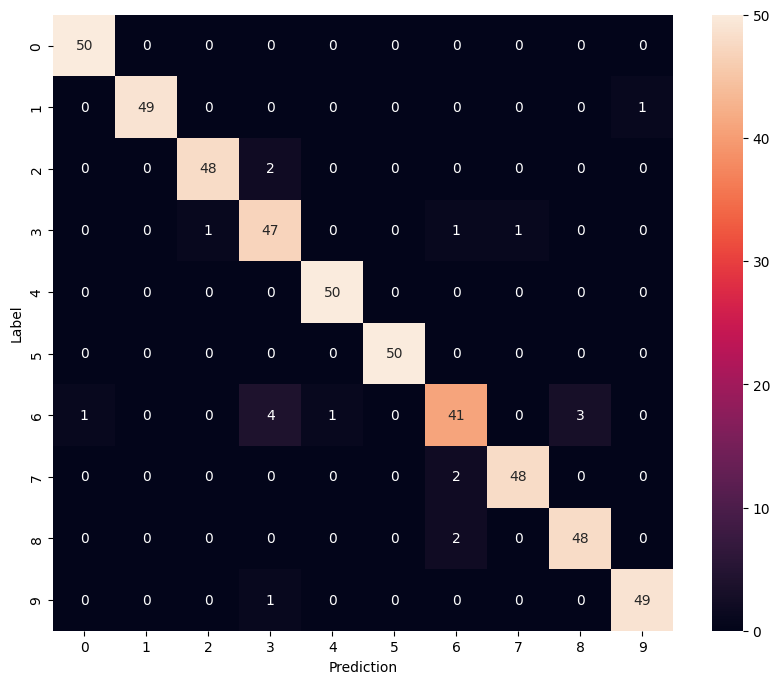

In [146]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_with_train_augmentation)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

El modelo muestra un rendimiento muy bueno en general, con una exactitud del 96%.

Hay un excelente desempeño en varias clases (0, 1, 4, 5, 9).

Las principales dificultades se encuentran en la clase 6, aunque sigue presentando una predicción mayormente acertada.

Se evalua el desempeño del modelo en el set de test

In [147]:
# Evaluate the model on the test set
test_loss_aug, test_accuracy_aug = model_cnn_with_augmentation.evaluate(test_spectrogram_ds)

print("Test Loss:", test_loss_aug)
print("Test Accuracy:", test_accuracy_aug)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9709 - loss: 0.1153
Test Loss: 0.17290130257606506
Test Accuracy: 0.9599999785423279


El nivel de accuracy del modelo para el set de test es significativamente elevado.

Inferir sobre un archivo de audio

Finalmente, se realizará inferencia sobre un archivo de audio (en este caso se toma un archivo del dataset arbitrario, podría ser un archivo .wav completamente nuevo).

In [324]:
# Función para añadir ruido
transform_noise = AddGaussianNoise(
    min_amplitude=0.015,
    max_amplitude=0.030,
    p=1.0
)

def add_noise(audio):
    augmented_audio_np = transform_noise(audio, sample_rate=8000)
    augmented_audio_tensor = tf.convert_to_tensor(augmented_audio_np)
    return augmented_audio_tensor

# Funciones de aumento de datos para el dataset
def augment_data_noise(audio):
    augmented_audio = tf.py_function(add_noise, [audio], tf.float32)
    augmented_audio.set_shape(audio.shape)
    return (augmented_audio)

Se realizará una predicción usando el modelo cuyo set de entrenamiento contenía tanto datos con ruido como sin él, sobre un audio específico (que será el mismo que se utilice para probar todos los modelos).

Primero se realizará la predicción sobre el audio sin ruido y luego sobre el mismo audio al que se le ha añadido ruido.

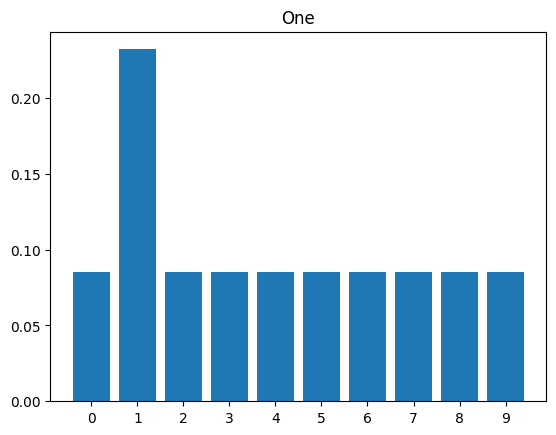

In [193]:
# Especificar el directorio de los archivos de audio
audio_dir = 'free-spoken-digit-dataset-1.0.9/recordings/test_set/1'

# Obtener la lista de archivos en el directorio
audio_files = os.listdir(audio_dir)

# Seleccionar el primer archivo de audio
first_audio_file = audio_files[0]

# Construir la ruta completa del archivo de audio
x = os.path.join(audio_dir, first_audio_file)
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model_cnn_with_augmentation(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('One')
plt.show()

display.display(display.Audio(waveform, rate=8000))

(8000,)


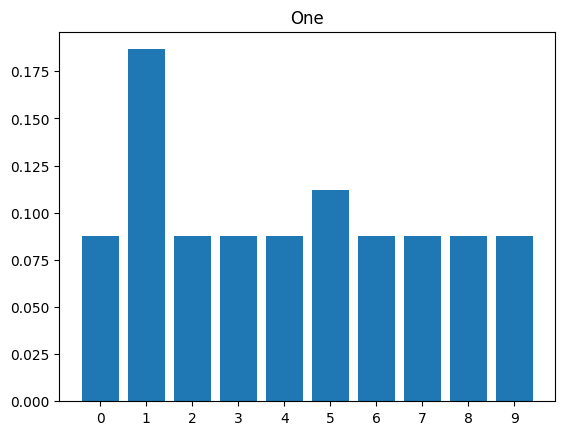

In [203]:
# Especificar el directorio de los archivos de audio
audio_dir = 'free-spoken-digit-dataset-1.0.9/recordings/test_set/1'

# Obtener la lista de archivos en el directorio
audio_files = os.listdir(audio_dir)

# Seleccionar el primer archivo de audio
first_audio_file = audio_files[0]

# Construir la ruta completa del archivo de audio
x = os.path.join(audio_dir, first_audio_file)
x = tf.io.read_file(str(x))

x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
print(x.shape)
x = augment_data_noise(x)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model_cnn_with_augmentation(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('One')
plt.show()

display.display(display.Audio(waveform, rate=8000))


Se observa que en ambos casos, el modelo predice correctamente el dígito. En el segundo caso, con ruido, detecta la clase 5 como la segunda más probable, una clase que suena similar a la verdadera en inglés. Aún así predice el label correctamente, aunque el ruido agregado es mayor que el que se añadió a los audios para el entrenamiento.

#### 4.1.2 Modelo de CNN para entrenamiento con set de datos sin augmentation

In [180]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spec_without_aug.map(map_func=lambda spec, label: spec))

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model_cnn.summary()

Input shape: (75, 65, 1)


2024-07-01 19:54:01.202507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [108]:
# Compilar el modelo
model_cnn.compile(
    optimizer='adam',  # Optimizador Adam
    loss='sparse_categorical_crossentropy',  # Función de pérdida categorical_crossentropy
    metrics=['accuracy']  # Métrica de evaluación: precisión (accuracy)
)

In [109]:
# Set up checkpointing
char_checkpoint = ModelCheckpoint(
    'checkpoints/models_audio_classification/model_cnn/model_cnn.{epoch:02d}-{val_loss:.2f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_weights_only=True,
    verbose=1
)

Se entrena el modelo

In [110]:
EPOCHS = 50
history = model_cnn.fit(
    train_spec_without_aug,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),char_checkpoint]
)

Epoch 1/50


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.3048 - loss: 2.0270
Epoch 1: val_loss improved from inf to 1.22084, saving model to checkpoints/char_model/models_audio_classification/model_cnn/model_cnn.01-1.22.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 432ms/step - accuracy: 0.3085 - loss: 2.0183 - val_accuracy: 0.6200 - val_loss: 1.2208
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6288 - loss: 1.2484
Epoch 2: val_loss improved from 1.22084 to 0.83024, saving model to checkpoints/char_model/models_audio_classification/model_cnn/model_cnn.02-0.83.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.6296 - loss: 1.2450 - val_accuracy: 0.7850 - val_loss: 0.8302
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.7312 - loss: 0.8858
Epoch 3: val_loss improved from 0.83024 to 0.62024, saving model to checkpoints/char_model/models_audio_classification/model_cnn/model_cnn.03-0.62.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accur

El modelo alcanza prontamente, en la época 5 de entrenamiento, un accuracy elevado. Demora tan solo una época más en alcanzar el nivel de accuracy que el modelo que se entrena con el set de datos con data augmentation.

Text(0, 0.5, 'Accuracy [%]')

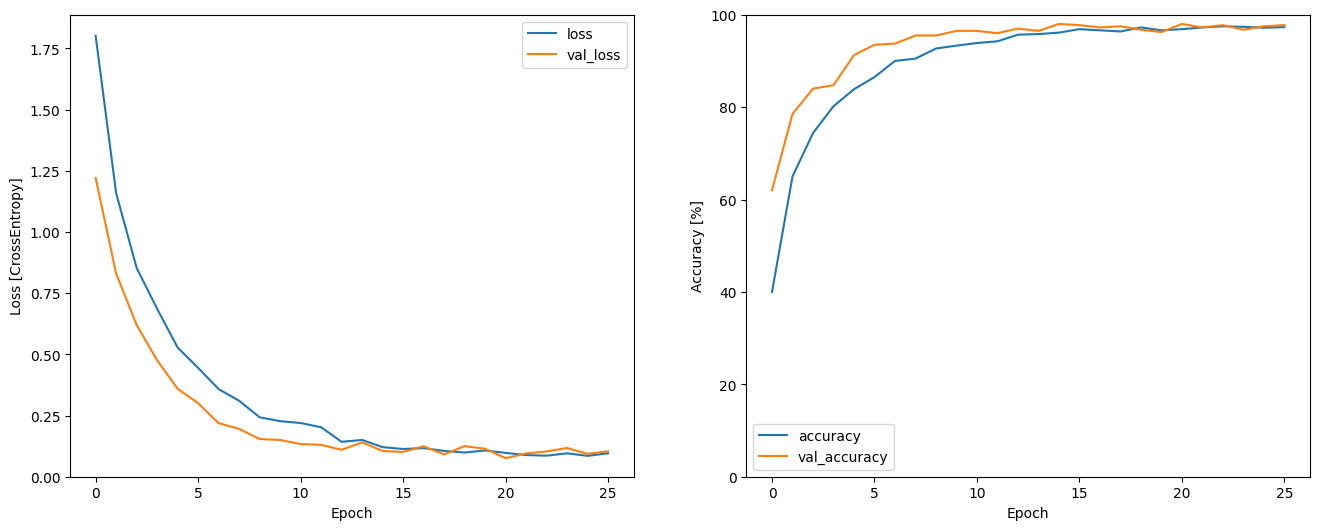

In [111]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

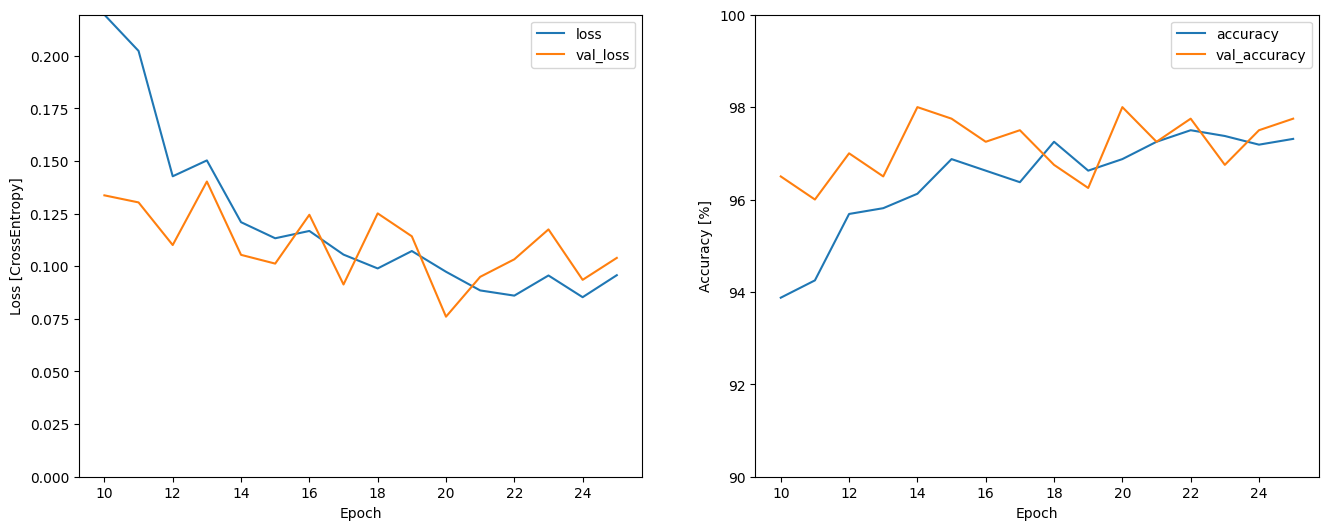

In [114]:
# Definir la época desde la que empezar a graficar
start_epoch = 10

# Filtrar los datos a partir de la época especificada
epochs = history.epoch[start_epoch:]
loss = metrics['loss'][start_epoch:]
val_loss = metrics['val_loss'][start_epoch:]
accuracy = 100 * np.array(metrics['accuracy'][start_epoch:])
val_accuracy = 100 * np.array(metrics['val_accuracy'][start_epoch:])

plt.figure(figsize=(16,6))

# Gráfico de loss
plt.subplot(1,2,1)
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.ylim([0, max(max(loss), max(val_loss))])  # Ajusta el límite superior al máximo valor de loss o val_loss
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

# Gráfico de accuracy
plt.subplot(1,2,2)
plt.plot(epochs, accuracy, label='accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.legend()
plt.ylim([90, 100])  # Define el rango específico para el accuracy
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()

Gráfico de loss:

La pérdida en el conjunto de entrenamiento disminuye de manera constante, similar al gráfico anterior, indicando un aprendizaje efectivo del modelo. En el conjunto de validación también sigue una tendencia decreciente, lo cual es positivo y sugiere una buena generalización inicial.

A partir de la época 10, ambas pérdidas (entrenamiento y validación) se estabilizan, sugiriendo convergencia del modelo.


Al igual que en el gráfico anterior, se observan pequeñas fluctuaciones en la pérdida de validación, lo cual es común y no necesariamente preocupante.

Gráfico de accuracy:

La exactitud del conjunto de entrenamiento aumenta rápidamente durante las primeras épocas, similar al gráfico anterior, alcanzando valores superiores al 80% alrededor de la época 5. La del conjunto de validación sigue una tendencia similar, indicando un buen aprendizaje inicial y generalización a datos no vistos.

Alrededor de la época 10, la exactitud de entrenamiento y validación se estabilizan cerca del 95%, similar al gráfico anterior.

Las curvas de entrenamiento y validación están muy cercanas, lo cual indica una buena generalización y ausencia de overfitting significativo.

- Predicciones

In [184]:
y_pred_cnn = model_cnn.predict(test_spectrogram_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step


In [185]:
y_pred_cnn = tf.argmax(y_pred_cnn, axis=1)

Mostrar una matriz de confusión
Se utiliza una matriz de confusión para verificar qué tan bien clasificó el modelo cada uno de los comandos en el conjunto de prueba

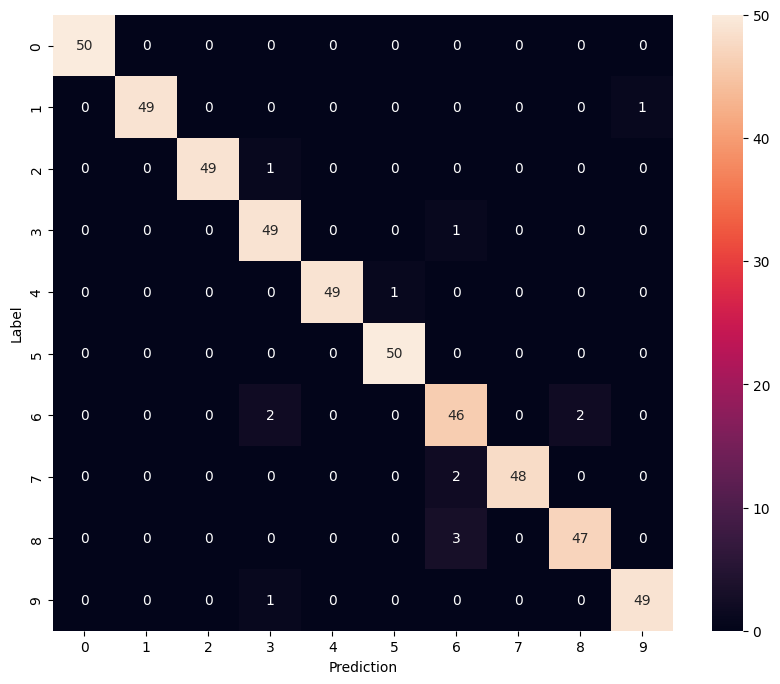

In [186]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

El modelo muestra un rendimiento muy bueno en general, con una exactitud del 97%.

Hay un excelente desempeño en todas las clases.

Las principales dificultades se encuentran en las clases 6, pero solo en 4 de 50 casos. Tal vez allí los audio eran muy similares a los de las otras clases predichas o se encontraban mal etiquetados.

In [187]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_cnn.evaluate(test_spectrogram_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9816 - loss: 0.0873
Test Loss: 0.13769572973251343
Test Accuracy: 0.972000002861023


Inferir sobre un archivo de audio

Finalmente, se realizará inferencia sobre un archivo de audio (en este caso se toma un archivo del dataset arbitrario, podría ser un archivo .wav completamente nuevo).

Se realizará una predicción usando el modelo cuyo set de entrenamiento contenía solo audios a los que no se les añadió ruido, sobre un audio específico (que será el mismo que se utilice para probar todos los modelos).

Primero se realizará la predicción sobre el audio sin ruido y luego sobre el mismo audio al que se le ha añadido ruido.

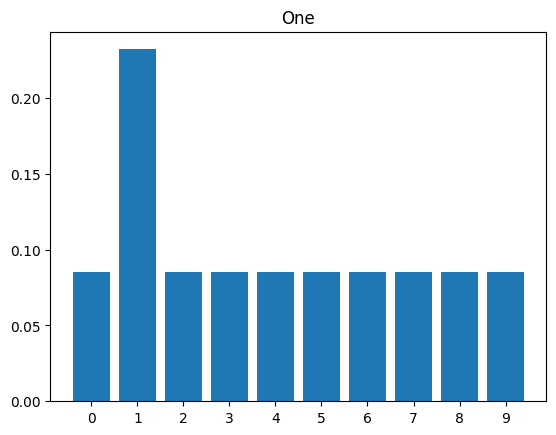

In [206]:
# Especificar el directorio de los archivos de audio
audio_dir = 'free-spoken-digit-dataset-1.0.9/recordings/test_set/1'

# Obtener la lista de archivos en el directorio
audio_files = os.listdir(audio_dir)

# Seleccionar el primer archivo de audio
first_audio_file = audio_files[0]

# Construir la ruta completa del archivo de audio
x = os.path.join(audio_dir, first_audio_file)
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model_cnn(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('One')
plt.show()

display.display(display.Audio(waveform, rate=8000))

(8000,)


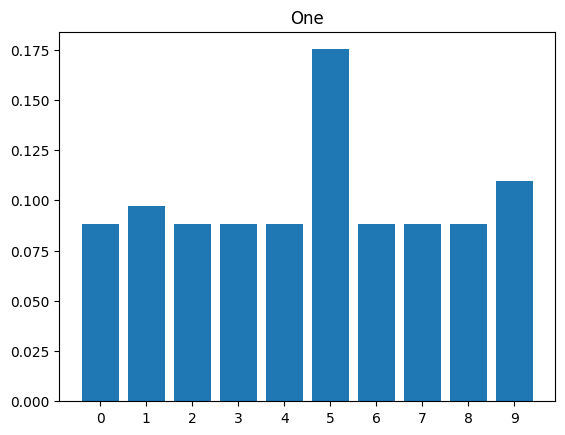

In [207]:
# Especificar el directorio de los archivos de audio
audio_dir = 'free-spoken-digit-dataset-1.0.9/recordings/test_set/1'

# Obtener la lista de archivos en el directorio
audio_files = os.listdir(audio_dir)

# Seleccionar el primer archivo de audio
first_audio_file = audio_files[0]

# Construir la ruta completa del archivo de audio
x = os.path.join(audio_dir, first_audio_file)
x = tf.io.read_file(str(x))

x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
print(x.shape)
x = augment_data_noise(x)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model_cnn(x)
x_labels = label_names
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('One')
plt.show()

display.display(display.Audio(waveform, rate=8000))

Se observa que en el primer caso, el modelo predice correctamente el dígito. Sin embargo, en el segundo caso, con ruido, el modelo predice un dígito que no es, confundiendo el one verdadero con un five. Se puede destacar que, aunque se equivoca, predice un dígito que suena similar al real.

### 4.2 Modelo de clasificación con redes neuronales recurrentes

Para el modelo, se utilizará una red neuronal convolucional simple (CNN) y redes neuronales recurrentes (RNN)

El modelo tf.keras.Sequential utilizará las siguientes capas de preprocesamiento de Keras:

La capa TimeDistributed en Keras/TensorFlow se utiliza para aplicar una capa (como Dense, Conv2D, MaxPooling2D, etc.) a cada "time step" de una secuencia de manera independiente. Esto es útil cuando se trabaja con secuencias de datos y se desea aplicar la misma operación en cada elemento de la secuencia de forma individual. En lugar de aplicar la operación a toda la secuencia de una sola vez, se aplica la operación a cada "frame" o "ventana" de la secuencia de manera independiente.

En resumen, TimeDistributed es una herramienta poderosa para aplicar operaciones en secuencias de datos, manteniendo la independencia de cada paso temporal y permitiendo una integración eficiente de redes convolucionales y recurrentes.



#### 4.2.1 Definición de funciones para crear secuencias

Función para dividir espectrogramas en ventanas con solapamiento

In [336]:
def slice_spectrogram(spectrogram, window_size, overlap):
    # Asumimos que la entrada es (batch_size, time, frequency, channels)
    batch_size, time, frequency, channels = spectrogram.shape
    print(spectrogram.shape)
    stride = window_size - overlap
    num_windows = (time - window_size) // stride + 1
    
    slices = []
    for i in range(num_windows):
        start = i * stride
        end = start + window_size
        slice_ = spectrogram[:, start:end, :, :]
        slices.append(slice_)
    
    return tf.stack(slices, axis=1)

a) La función toma tres argumentos:

- spectrogram: El espectrograma a recortar.
- window_size: El tamaño de cada recorte en el eje del tiempo.
- overlap: La cantidad de superposición entre recortes adyacentes.

b) Se extraen las dimensiones del espectrograma: 
    
    batch_size, time, frequency, channels = spectrogram.shape

Esto nos da el tamaño del batch, la longitud del eje de tiempo, la altura del eje de frecuencia y el número de canales.

c) Se calcula el stride (paso):
    
    stride = window_size - overlap
Esto determina cuánto nos movemos entre cada recorte.

d) Se calcula el número de ventanas (recortes) que obtendremos:
    
    num_windows = (time - window_size) // stride + 1
Se usa división entera (//) para asegurarnos de obtener un número entero de ventanas.

e) Se inicializa una lista vacía para almacenar los recortes:
    
    slices = []

f) Se itera para crear cada recorte:
    
    for i in range(num_windows):
        start = i * stride
        end = start + window_size
        slice_ = spectrogram[:, start:end, :, :]
        slices.append(slice_)
En cada iteración:

Se calcula el inicio y fin del recorte en el eje del tiempo.

Se extrae el recorte del espectrograma.

Se añade el recorte a la lista slices.

g) Finalmente, se apilan todos los recortes en un nuevo tensor:
    
    return tf.stack(slices, axis=1)
Esto crea un tensor con forma (batch_size, num_windows, window_size, frequency, channels).

Función para actualizar el set de datos de entrenamiento

In [274]:
def prepare_dataset_for_lstm(dataset, window_size=15, overlap=3):
    def preprocess(spec, label):
        sliced_spec = slice_spectrogram(spec, window_size, overlap)
        return sliced_spec, label
    
    return dataset.map(preprocess)

a) La función toma tres argumentos:

- dataset: El dataset de TensorFlow que contiene los espectrogramas y etiquetas.
- window_size: El tamaño de cada recorte (por defecto 15).
- overlap: La superposición entre recortes (por defecto 3).

b) Se define una función interna preprocess:
    
    def preprocess(spec, label):
        sliced_spec = slice_spectrogram(spec, window_size, overlap)
        return sliced_spec, label
Esta función:

- Toma un espectrograma y su etiqueta.
- Aplica la función slice_spectrogram al espectrograma.
- Devuelve el espectrograma recortado y la etiqueta original.

c) Se aplica la función preprocess a todo el dataset:

    return dataset.map(preprocess)
El método map de TensorFlow aplica la función preprocess a cada elemento del dataset.

Se aplican las funciones definidas a los datos

In [275]:
# Set de datos de entrenamiento con augmentation
train_spectrogram_ds_with_augmentation = train_spectrogram_ds_with_augmentation.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
# Set de datos de entrenamiento sin augmentation
train_spec_without_aug = train_spec_without_aug.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)

In [276]:
for example_s, example_l in train_spectrogram_ds_with_augmentation.take(1):
  break

In [277]:
# Aplicar la función a nuestro dataset
window_size = 15  # Tamaño de la ventana de tiempo
overlap = 3  # Superposición entre ventanas

train_spectrogram_ds_for_lstm_aug = prepare_dataset_for_lstm(train_spectrogram_ds_with_augmentation, window_size, overlap)
train_spec = prepare_dataset_for_lstm(train_spec_without_aug, window_size, overlap)
val_spectrogram_ds_for_lstm = prepare_dataset_for_lstm(val_spectrogram_ds, window_size, overlap)

# Verificar la forma de los datos
for specs, labels in train_spectrogram_ds_for_lstm_aug.take(1):
    print("Forma de los espectrogramas:", specs.shape)
    print("Forma de las etiquetas:", labels.shape)

(None, 75, 65, 1)
(None, 75, 65, 1)
(None, 75, 65, 1)
Forma de los espectrogramas: (64, 6, 15, 65, 1)
Forma de las etiquetas: (64,)


2024-07-01 21:54:04.054763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


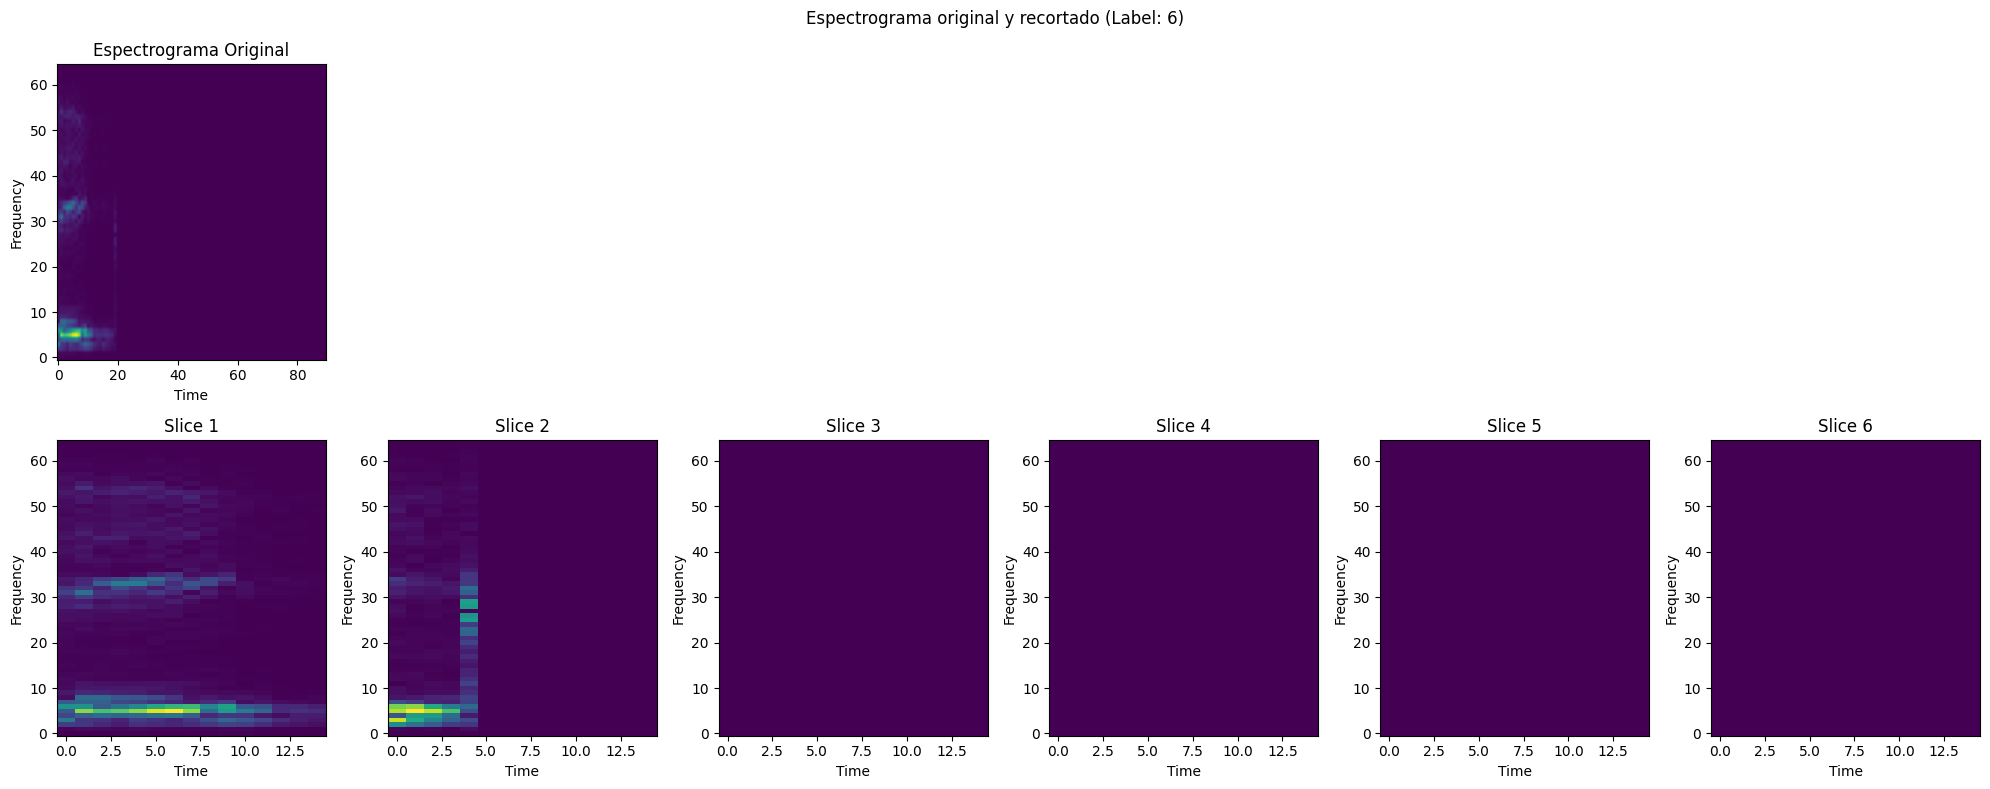

2024-07-01 21:54:36.449002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [282]:
def visualize_sliced_spectrograms(dataset, num_examples=1):
    for specs, labels in dataset.take(num_examples):
        batch_size, num_slices, time, frequency, channels = specs.shape
        
        # Seleccionar un espectrograma aleatorio del batch
        random_index = np.random.randint(0, batch_size)
        sliced_spec = specs[random_index]
        
        # Crear una figura con subplots para cada slice y el espectrograma original
        fig, axes = plt.subplots(2, max(num_slices, 1), figsize=(20, 8))
        fig.suptitle(f"Espectrograma original y recortado (Label: {labels[random_index]})")
        
        # Mostrar el espectrograma original
        original_spec = tf.concat(tf.unstack(sliced_spec), axis=0)
        axes[0, 0].imshow(tf.transpose(original_spec[:,:,0]).numpy(), aspect='auto', origin='lower', cmap='viridis')
        axes[0, 0].set_title("Espectrograma Original")
        axes[0, 0].set_xlabel('Time')
        axes[0, 0].set_ylabel('Frequency')
        
        # Ocultar los ejes extras en la primera fila
        for ax in axes[0, 1:]:
            ax.axis('off')
        
        # Mostrar cada slice
        for i in range(num_slices):
            axes[1, i].imshow(tf.transpose(sliced_spec[i,:,:,0]).numpy(), aspect='auto', origin='lower', cmap='viridis')
            axes[1, i].set_title(f"Slice {i+1}")
            axes[1, i].set_xlabel('Time')
            axes[1, i].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()

# Visualizar un ejemplo
visualize_sliced_spectrograms(train_spectrogram_ds_for_lstm_aug)

#### 4.2.2 Modelo de CNN-RNN para entrenamiento con set de datos con augmentation

Explicación:
- Objetivo: Crear un modelo que combine CNN y LSTM para procesar secuencias de ventanas de espectrogramas.

Componentes del modelo:
- input_shape: Define la forma de entrada como (num_splits, window_size, 65, 1).

- layers.TimeDistributed(layers.Conv2D(...)): Aplica una capa Conv2D a cada ventana de la secuencia.

- layers.TimeDistributed(layers.MaxPooling2D()): Aplica un MaxPooling2D a cada ventana de la secuencia.

- layers.TimeDistributed(layers.Dropout(0.25)): Aplica Dropout para regularización.

- layers.TimeDistributed(layers.Flatten()): Aplana cada ventana antes de pasar a la LSTM.

- layers.LSTM(128, return_sequences=True): Aplica una LSTM a la secuencia de ventanas, manteniendo las secuencias.

- layers.LSTM(128): Aplica otra LSTM, esta vez retornando solo el estado final.

- layers.Dropout(0.5): Otro Dropout para regularización.

- layers.Dense(num_labels, activation='softmax'): Capa de salida con activación softmax para clasificación.

In [307]:
input_shape = (6, 15, 65, 1)  # (time_steps, height, width, channels)
num_labels = len(label_names)

model_cnn_lstm_aug = models.Sequential([
    layers.Input(shape=input_shape),
    
    # CNN parte
    layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv2D(64, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling2D()),
    layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv2D(64, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling2D()),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.Dropout(0.25)),
    
    # Aplanar preservando la dimensión temporal
    layers.TimeDistributed(layers.Flatten()),
    
    
    # LSTM parte
    #layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    
    layers.Dense(32, activation='relu'),
    
    # Clasificación
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

model_cnn_lstm_aug.summary()



Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_76             │ (None, 6, 15, 65, 32)  │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_77             │ (None, 6, 15, 65, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_78             │ (None, 6, 7, 32, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_79             │ (None, 6, 7, 32, 32)   │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_80             │ (None, 6, 7, 32, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_81             │ (None, 6, 3, 16, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_82             │ (None, 6, 3, 16, 64)   │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_83             │ (None, 6, 3, 16, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_84             │ (None, 6, 3072)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 32)             │       397,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,858 (1.74 MB)

 Trainable params: 454,730 (1.73 MB)

 Non-trainable params: 128 (512.00 B)

In [308]:
# Compilar el modelo
model_cnn_lstm_aug.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Se entrena el modelo

In [309]:
# Set up checkpointing
char_checkpoint = ModelCheckpoint(
    'checkpoints/models_audio_classification/model_rnn_aug/model_rnn_aug.{epoch:02d}-{val_loss:.2f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_weights_only=True,
    verbose=1
)

In [310]:
EPOCHS = 50

history = model_cnn_lstm_aug.fit(
    train_spectrogram_ds_for_lstm_aug,
    validation_data=val_spectrogram_ds_for_lstm,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
        char_checkpoint
    ]
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1498 - loss: 2.2044
Epoch 1: val_loss improved from inf to 1.96825, saving model to checkpoints/char_model/models_audio_classification/model_rnn_aug/model_rnn_aug.01-1.97.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.1508 - loss: 2.2024 - val_accuracy: 0.3400 - val_loss: 1.9682
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3496 - loss: 1.6997
Epoch 2: val_loss improved from 1.96825 to 1.53103, saving model to checkpoints/char_model/models_audio_classification/model_rnn_aug/model_rnn_aug.02-1.53.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.3503 - loss: 1.6979 - val_accuracy: 0.4900 - val_loss: 1.5310
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5017 - loss: 1.3184
Epoch 3: val_loss improved from 1.53103 to 0.98818, saving model to checkpoints/char_model/models_audio_classification/model_rnn_aug/model_rnn_aug.03-0.99.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━

Text(0, 0.5, 'Accuracy [%]')

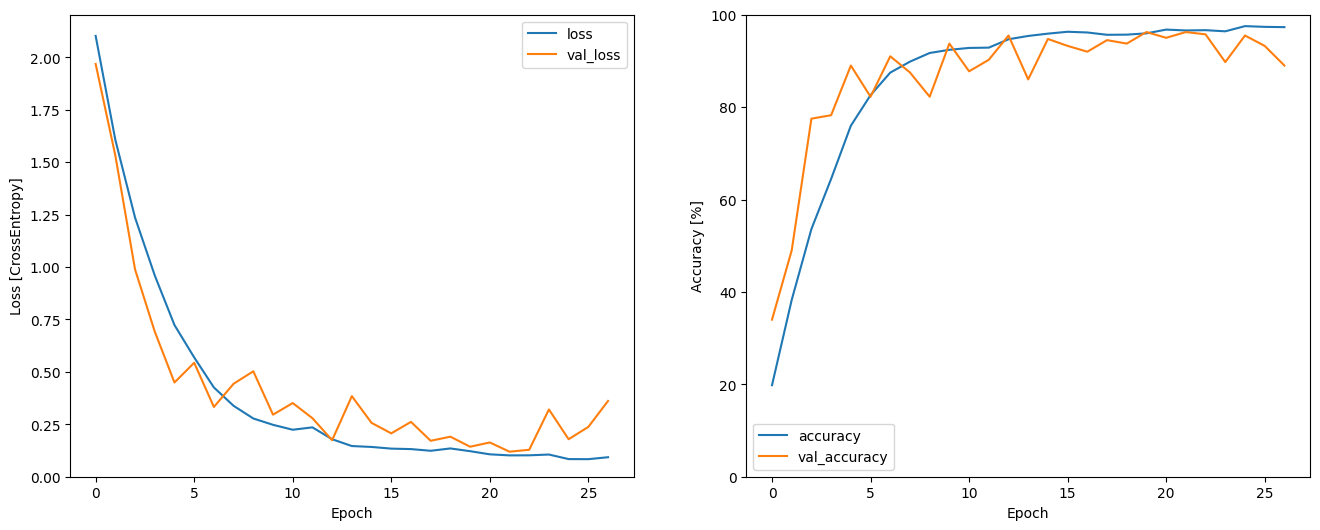

In [311]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Gráfico de loss:

La pérdida en el conjunto de entrenamiento disminuye de manera constante, lo cual indica que el modelo está aprendiendo. En el conjunto de validación sigue una tendencia decreciente similar, sugiriendo buena generalización inicial.

El loss se estabiliza alrededor de la época 20, similar a los gráficos anteriores. Se observan más fluctuaciones en la pérdida de validación comparado con los gráficos anteriores, lo cual podría indicar una mayor sensibilidad del modelo a los datos de validación.

Gráfico de accuracy:

La exactitud del conjunto de entrenamiento aumenta rápidamente durante las primeras épocas, alcanzando valores superiores al 80% alrededor de la época 5, similar a los gráficos anteriores. La del conjunto de validación sigue una tendencia similar, indicando un buen aprendizaje inicial.

Se estabiliza alrededor de la época 10, similar a los gráficos anteriores. Se observan más fluctuaciones en la exactitud de validación en comparación con los gráficos anteriores, lo cual podría ser debido a la adición de ruido a los datos de entrenamiento.

La mayor variabilidad en la exactitud y pérdida de validación podría indicar que la adición de ruido está desafiando al modelo, lo cual puede ser positivo para mejorar su robustez, aunque también puede requerir ajustes adicionales en los hiperparámetros.

#### Acondicionamiento del set de test

In [312]:
# Aplicar la función a nuestro dataset de prueba
window_size = 15  # Tamaño de la ventana de tiempo
overlap = 3  # Superposición entre ventanas

test_spectrogram_ds_for_lstm = prepare_dataset_for_lstm(test_spectrogram_ds, window_size, overlap)

# Verificar la forma de los datos de prueba preparados
for specs_test, labels_test in test_spectrogram_ds_for_lstm.take(1):
    print("Forma de los espectrogramas de prueba:", specs_test.shape)
    print("Forma de las etiquetas de prueba:", labels_test.shape)

(None, 75, 65, 1)
Forma de los espectrogramas de prueba: (64, 6, 15, 65, 1)
Forma de las etiquetas de prueba: (64,)


2024-07-02 17:38:33.088418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


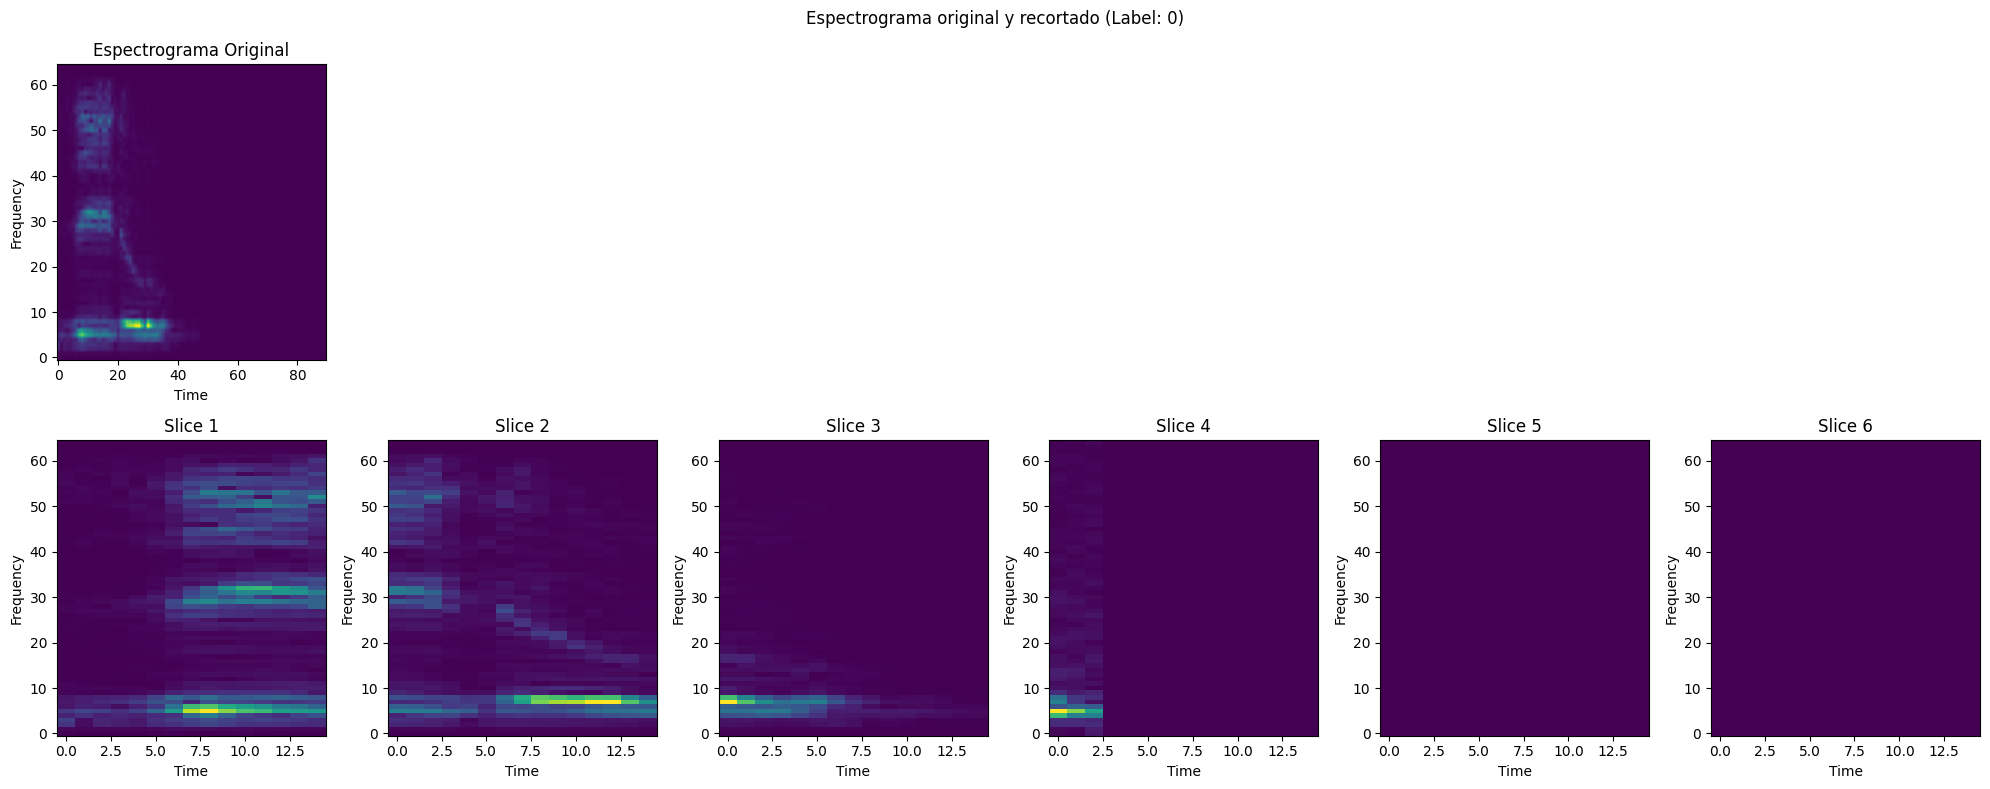

2024-07-02 09:22:01.544412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [289]:
visualize_sliced_spectrograms(test_spectrogram_ds_for_lstm, num_examples=1)

- Predicciones

In [313]:
predictions = model_cnn_lstm_aug.predict(test_spectrogram_ds_for_lstm)
# Las predicciones serán probabilidades para cada clase
# Podemos obtener la clase predicha tomando el argmax
predicted_classes = tf.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 570ms/step


In [314]:
y_true = tf.concat(list(test_spectrogram_ds_for_lstm.map(lambda s,lab: lab)), axis=0)

2024-07-02 17:38:57.876484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mostrar una matriz de confusión
Se utiliza una matriz de confusión para verificar qué tan bien clasificó el modelo cada uno de los comandos en el conjunto de prueba

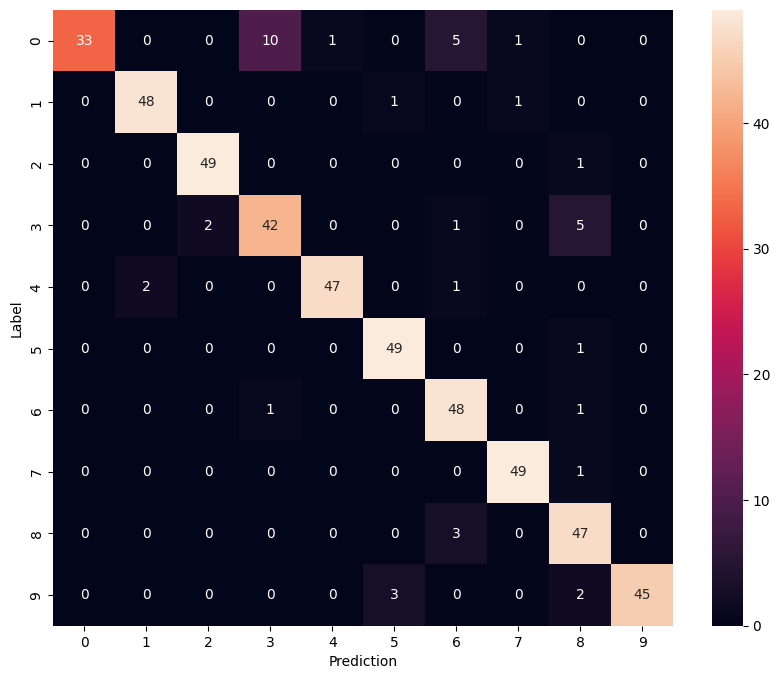

In [315]:
confusion_mtx = tf.math.confusion_matrix(y_true, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Rendimiento general:
El modelo muestra un buen rendimiento general. La diagonal principal de la matriz contiene los valores más altos, lo que indica que el modelo clasifica correctamente la mayoría de las instancias para cada clase.

El modelo combinado CNN-LSTM muestra un rendimiento sólido en la mayoría de las clases. Hay algunas confusiones específicas que podrían abordarse para mejorar aún más el rendimiento, especialmente para la clase 3.
El rendimiento es robusto y generaliza bien en los datos de prueba.

Para las predicciones no acertadas de la clase 3 y la clase 0, puede ser que los espectrogramas de las clases predichas sean simiares al label real o que, directamente, haya habido casos de etiquetado de datos incorrecto.



Se evalua el desempeño del modelo en el set de test

In [316]:
# Evaluate the model on the test set
test_loss_rnn_aug, test_accuracy_rnn_aug = model_cnn_lstm_aug.evaluate(test_spectrogram_ds_for_lstm)

print("Test Loss:", test_loss_rnn_aug)
print("Test Accuracy:", test_accuracy_rnn_aug)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.8734 - loss: 0.4172
Test Loss: 0.3068932592868805
Test Accuracy: 0.9139999747276306


El nivel de accuracy del modelo para el set de test es bastante elevado. Sin embargo, es considerablemente menor al obtenido con los modelos anteriores de CNN.

Inferir sobre un archivo de audio

Finalmente, se realizará inferencia sobre un archivo de audio (en este caso se toma un archivo del dataset arbitrario, podría ser un archivo .wav completamente nuevo).

Se realizará una predicción usando el modelo cuyo set de entrenamiento contenía tanto datos con ruido como sin él, sobre un audio específico (que será el mismo que se utilice para probar todos los modelos).

Primero se realizará la predicción sobre el audio sin ruido y luego sobre el mismo audio al que se le ha añadido ruido.

(1, 75, 65, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


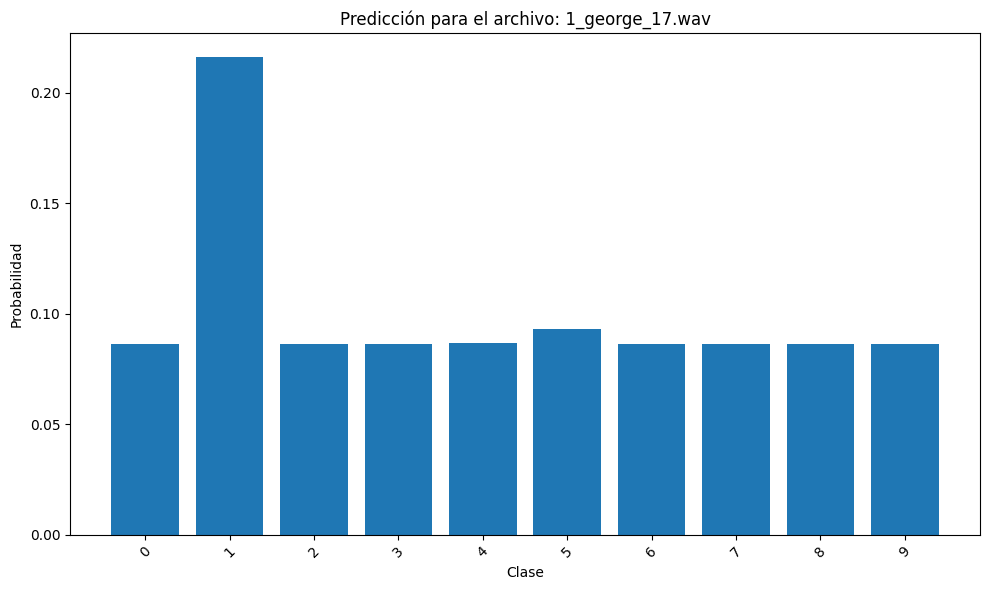

Clase predicha: 1
Probabilidad: 0.2162


In [317]:
# Especificar el directorio de los archivos de audio
audio_dir = 'free-spoken-digit-dataset-1.0.9/recordings/test_set/1'

# Obtener la lista de archivos en el directorio
audio_files = os.listdir(audio_dir)

# Seleccionar el primer archivo de audio
first_audio_file = audio_files[0]

# Construir la ruta completa del archivo de audio
file_path = os.path.join(audio_dir, first_audio_file)

# Leer y decodificar el archivo de audio
x = tf.io.read_file(str(file_path))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
x = tf.squeeze(x, axis=-1)
waveform = x

x = get_spectrogram(x)
x = x[tf.newaxis,...]  # Agregar dimensión de batch

x_sliced = slice_spectrogram(x, 15, 3)

# Hacer la predicción con el modelo CNN-LSTM
prediction = model_cnn_lstm_aug.predict(x_sliced)

# Obtener las probabilidades
probabilities = tf.nn.softmax(prediction[0])

# Graficar las probabilidades
plt.figure(figsize=(10, 6))
plt.bar(label_names, probabilities)
plt.title(f'Predicción para el archivo: {first_audio_file}')
plt.ylabel('Probabilidad')
plt.xlabel('Clase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar el audio
display.display(display.Audio(waveform, rate=8000))

# Imprimir la clase predicha
predicted_class = label_names[np.argmax(probabilities)]
print(f"Clase predicha: {predicted_class}")
print(f"Probabilidad: {np.max(probabilities):.4f}")

(8000,)
(1, 75, 65, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


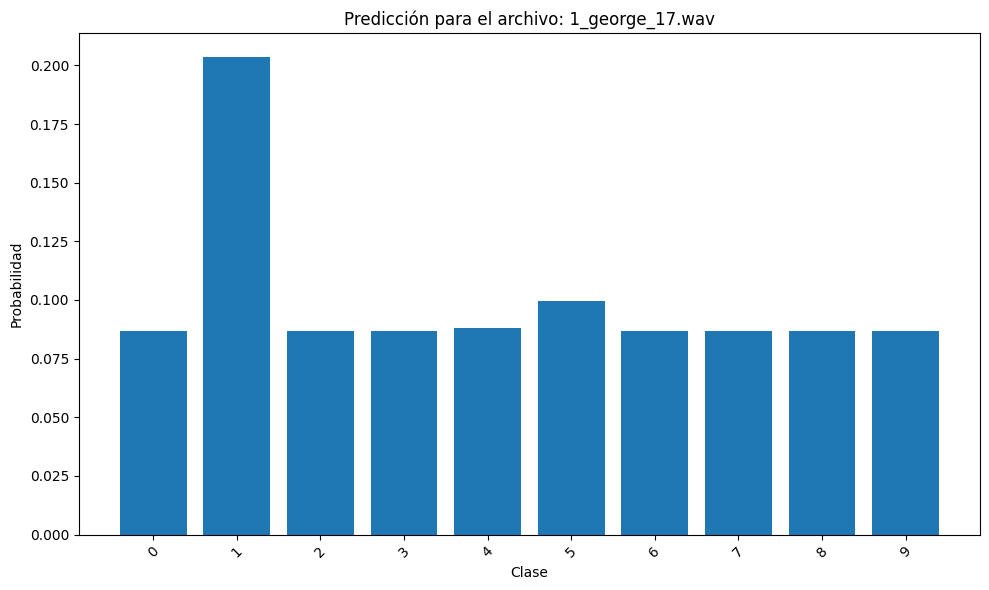

Clase predicha: 1
Probabilidad: 0.2037


In [325]:
# Especificar el directorio de los archivos de audio
audio_dir = 'free-spoken-digit-dataset-1.0.9/recordings/test_set/1'

# Obtener la lista de archivos en el directorio
audio_files = os.listdir(audio_dir)

# Seleccionar el primer archivo de audio
first_audio_file = audio_files[0]

# Construir la ruta completa del archivo de audio
file_path = os.path.join(audio_dir, first_audio_file)

# Leer y decodificar el archivo de audio
x = tf.io.read_file(str(file_path))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
print(x.shape)
x = augment_data_noise(x)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

x_sliced = slice_spectrogram(x, 15, 3)

# Hacer la predicción con el modelo CNN-LSTM
prediction = model_cnn_lstm_aug.predict(x_sliced)

# Obtener las probabilidades
probabilities = tf.nn.softmax(prediction[0])

# Graficar las probabilidades
plt.figure(figsize=(10, 6))
plt.bar(label_names, probabilities)
plt.title(f'Predicción para el archivo: {first_audio_file}')
plt.ylabel('Probabilidad')
plt.xlabel('Clase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar el audio
display.display(display.Audio(waveform, rate=8000))

# Imprimir la clase predicha
predicted_class = label_names[np.argmax(probabilities)]
print(f"Clase predicha: {predicted_class}")
print(f"Probabilidad: {np.max(probabilities):.4f}")

Se observa que en ambos casos, el modelo predice correctamente el dígito. En el segundo caso, con ruido, detecta la clase 5 como la segunda más probable, una clase que suena similar a la verdadera en inglés. Aún así predice el label correctamente, aunque el ruido agregado es mayor que el que se añadió a los audios para el entrenamiento.

#### 4.2.3 Modelo de RNN para entrenamiento con set de datos sin augmentation

In [326]:
input_shape = (6, 15, 65, 1)  # (time_steps, height, width, channels)
num_labels = len(label_names)

model_cnn_lstm = models.Sequential([
    layers.Input(shape=input_shape),
    
    # CNN parte
    layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv2D(64, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling2D()),
    layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.Conv2D(64, 3, activation='relu', padding='same')),
    layers.TimeDistributed(layers.MaxPooling2D()),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.Dropout(0.25)),
    
    # Aplanar preservando la dimensión temporal
    layers.TimeDistributed(layers.Flatten()),
    
    
    # LSTM parte
    #layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    
    layers.Dense(32, activation='relu'),
    
    # Clasificación
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

model_cnn_lstm.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_85             │ (None, 6, 15, 65, 32)  │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_86             │ (None, 6, 15, 65, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_87             │ (None, 6, 7, 32, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_88             │ (None, 6, 7, 32, 32)   │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_89             │ (None, 6, 7, 32, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_90             │ (None, 6, 3, 16, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_91             │ (None, 6, 3, 16, 64)   │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_92             │ (None, 6, 3, 16, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_93             │ (None, 6, 3072)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 32)             │       397,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,858 (1.74 MB)

 Trainable params: 454,730 (1.73 MB)

 Non-trainable params: 128 (512.00 B)

In [327]:
# Compilar el modelo
model_cnn_lstm.compile(
    optimizer='adam',  # Optimizador Adam
    loss='sparse_categorical_crossentropy',  # Función de pérdida categorical_crossentropy
    metrics=['accuracy']  # Métrica de evaluación: precisión (accuracy)
)

In [328]:
# Set up checkpointing
char_checkpoint = ModelCheckpoint(
    'checkpoints/models_audio_classification/model_rnn/model_rnn.{epoch:02d}-{val_loss:.2f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    save_weights_only=True,
    verbose=1
)

In [329]:
EPOCHS = 50
history = model_cnn_lstm.fit(
    train_spec,
    validation_data=val_spectrogram_ds_for_lstm,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5), char_checkpoint]
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1030 - loss: 2.2868
Epoch 1: val_loss improved from inf to 2.23036, saving model to checkpoints/char_model/models_audio_classification/model_rnn/model_rnn.01-2.23.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.1044 - loss: 2.2857 - val_accuracy: 0.1975 - val_loss: 2.2304
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1923 - loss: 2.1329
Epoch 2: val_loss improved from 2.23036 to 1.98201, saving model to checkpoints/char_model/models_audio_classification/model_rnn/model_rnn.02-1.98.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.1939 - loss: 2.1294 - val_accuracy: 0.3875 - val_loss: 1.9820
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3286 - loss: 1.7919
Epoch 3: val_loss improved from 1.98201 to 1.74086, saving model to checkpoints/char_model/models_audio_classification/model_rnn/model_rnn.03-1.74.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy:

Text(0, 0.5, 'Accuracy [%]')

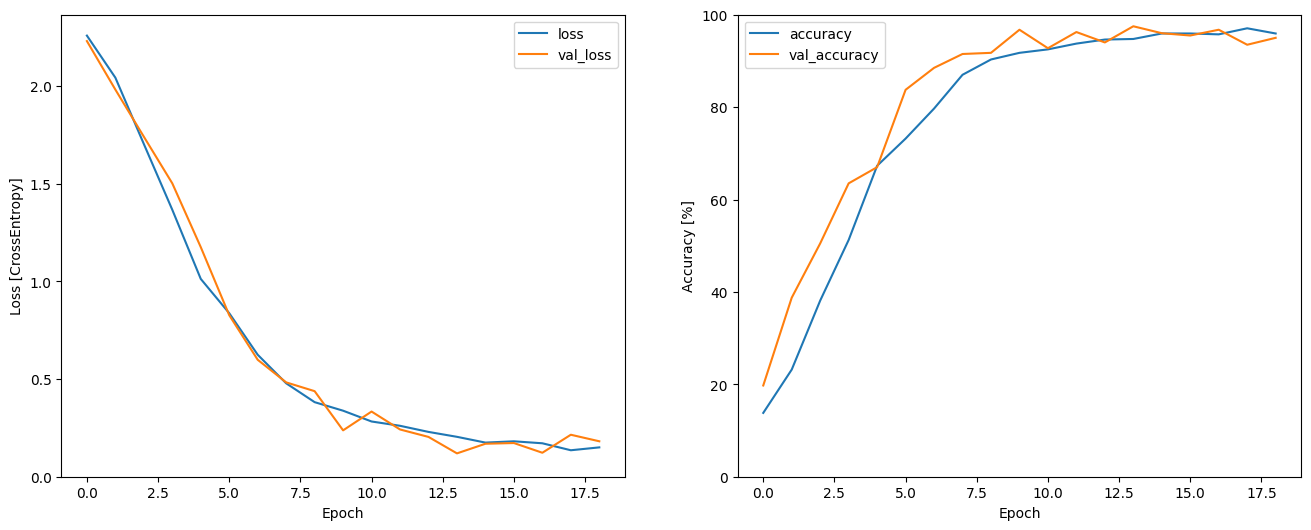

In [330]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Gráfico de loss:

Inicia alrededor de 2.3 y disminuye rápidamente en las primeras 5 épocas. La reducción de loss se ralentiza después de la época 7.5. Al final del entrenamiento, el loss se estabiliza alrededor de 0.2 tanto para entrenamiento como para validación.

El modelo muestra una clara mejora tanto en la reducción de loss a lo largo de las épocas, indicando que está aprendiendo efectivamente de los datos., al igual que en los gráficos de los modelos anteriores.

Gráfico de accuracy:

Comienza alrededor del 15% y aumenta rápidamente en las primeras 5 épocas. Alcanza aproximadamente el 90% de accuracy alrededor de la época 10. Después de la época 10, el accuracy continúa mejorando pero a un ritmo más lento.

No hay signos claros de overfitting, ya que las curvas de entrenamiento y validación para accuracy y loss se mantienen muy cercanas entre sí. Esto sugiere que el modelo generaliza bien a datos no vistos.

- Predicciones

In [331]:
# Hacer predicciones
predictions = model_cnn_lstm.predict(test_spectrogram_ds_for_lstm)

# Las predicciones serán probabilidades para cada clase
# Podemos obtener la clase predicha tomando el argmax
predicted_digits = np.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 912ms/step


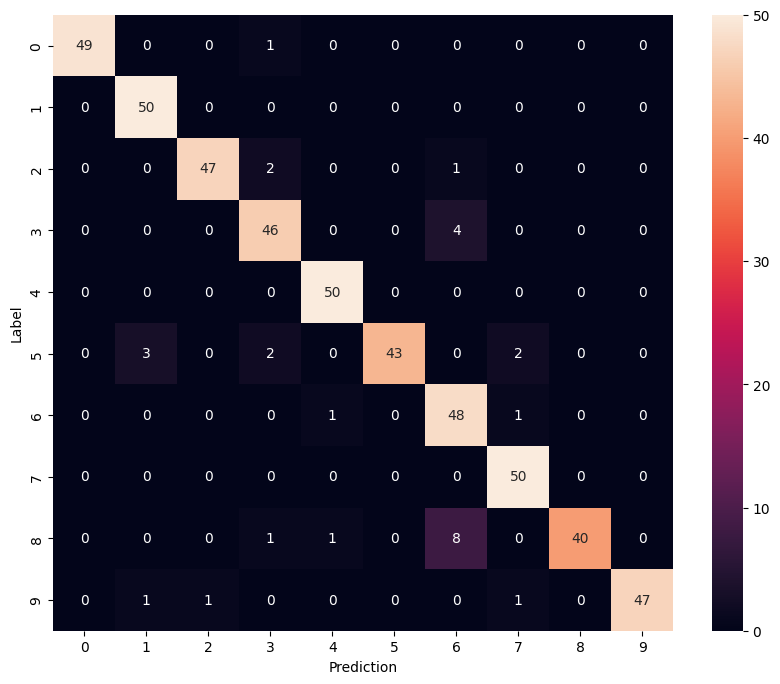

In [332]:
confusion_mtx = tf.math.confusion_matrix(y_true, predicted_digits)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

El modelo muestra un rendimiento muy bueno en general, con una exactitud del 94%.

Hay un excelente desempeño en varias clases (1, 4, 7, 0, 6).

Las principales dificultades se encuentran en las clases 8 y 5. La confusión más significativa es entre la clase 8 y la clase 6.

Se evalua el desempeño del modelo en el set de test

In [333]:
# Evaluate the model on the test set
test_loss_rnn, test_accuracy_rnn = model_cnn_lstm.evaluate(test_spectrogram_ds_for_lstm)

print("Test Loss:", test_loss_rnn)
print("Test Accuracy:", test_accuracy_rnn)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.9572 - loss: 0.1438
Test Loss: 0.18191392719745636
Test Accuracy: 0.9399999976158142


Inferir sobre un archivo de audio

Finalmente, se realizará inferencia sobre un archivo de audio (en este caso se toma un archivo del dataset arbitrario, podría ser un archivo .wav completamente nuevo).

(1, 75, 65, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


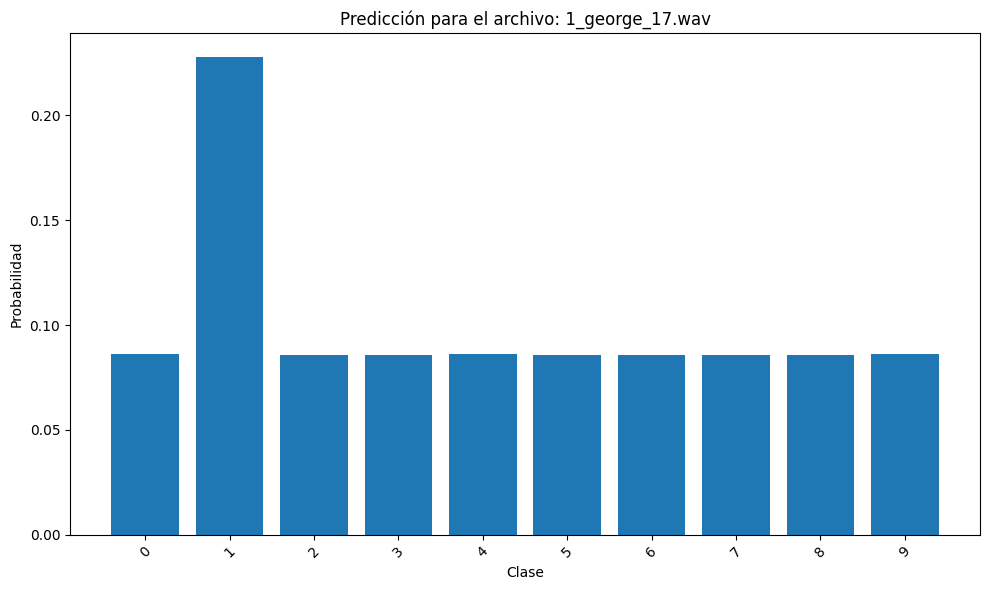

Clase predicha: 1
Probabilidad: 0.2280


In [337]:
# Especificar el directorio de los archivos de audio
audio_dir = 'free-spoken-digit-dataset-1.0.9/recordings/test_set/1'

# Obtener la lista de archivos en el directorio
audio_files = os.listdir(audio_dir)

# Seleccionar el primer archivo de audio
first_audio_file = audio_files[0]

# Construir la ruta completa del archivo de audio
file_path = os.path.join(audio_dir, first_audio_file)

# Leer y decodificar el archivo de audio
x = tf.io.read_file(str(file_path))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000)
x = tf.squeeze(x, axis=-1)
waveform = x

x = get_spectrogram(x)
x = x[tf.newaxis,...]  # Agregar dimensión de batch

x_sliced = slice_spectrogram(x, 15, 3)

# Hacer la predicción con el modelo CNN-LSTM
prediction = model_cnn_lstm.predict(x_sliced)

# Obtener las probabilidades
probabilities = tf.nn.softmax(prediction[0])

# Graficar las probabilidades
plt.figure(figsize=(10, 6))
plt.bar(label_names, probabilities)
plt.title(f'Predicción para el archivo: {first_audio_file}')
plt.ylabel('Probabilidad')
plt.xlabel('Clase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar el audio
display.display(display.Audio(waveform, rate=8000))

# Imprimir la clase predicha
predicted_class = label_names[np.argmax(probabilities)]
print(f"Clase predicha: {predicted_class}")
print(f"Probabilidad: {np.max(probabilities):.4f}")

(8000,)
(1, 75, 65, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


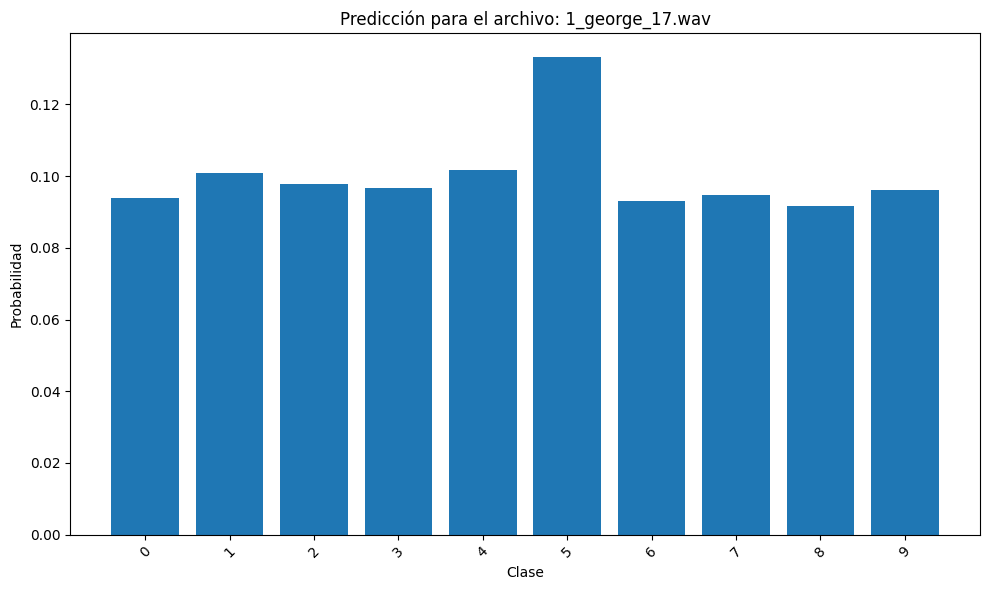

Clase predicha: 5
Probabilidad: 0.1333


In [338]:
# Especificar el directorio de los archivos de audio
audio_dir = 'free-spoken-digit-dataset-1.0.9/recordings/test_set/1'

# Obtener la lista de archivos en el directorio
audio_files = os.listdir(audio_dir)

# Seleccionar el primer archivo de audio
first_audio_file = audio_files[0]

# Construir la ruta completa del archivo de audio
file_path = os.path.join(audio_dir, first_audio_file)

# Leer y decodificar el archivo de audio
x = tf.io.read_file(str(file_path))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=8000,)
x = tf.squeeze(x, axis=-1)
waveform = x
print(x.shape)
x = augment_data_noise(x)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

x_sliced = slice_spectrogram(x, 15, 3)

# Hacer la predicción con el modelo CNN-LSTM
prediction = model_cnn_lstm.predict(x_sliced)

# Obtener las probabilidades
probabilities = tf.nn.softmax(prediction[0])

# Graficar las probabilidades
plt.figure(figsize=(10, 6))
plt.bar(label_names, probabilities)
plt.title(f'Predicción para el archivo: {first_audio_file}')
plt.ylabel('Probabilidad')
plt.xlabel('Clase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar el audio
display.display(display.Audio(waveform, rate=8000))

# Imprimir la clase predicha
predicted_class = label_names[np.argmax(probabilities)]
print(f"Clase predicha: {predicted_class}")
print(f"Probabilidad: {np.max(probabilities):.4f}")

Se observa que en el primer caso, el modelo predice correctamente el dígito. Sin embargo, en el segundo caso, con ruido, el modelo predice un dígito que no es, confundiendo el one verdadero con un five. Se puede destacar que, aunque se equivoca, predice un dígito que suena similar al real. Además, todas las otras clases aumentaron su posibilidad de ser predichas como la clase perteneciente al audio.

## Conclusiones

Análisis comparativo:

1. Rendimiento en el conjunto de prueba:

    - CNN con datos con y sin ruido: 95.99% de precisión
    - CNN sin datos con ruido: 97.20% de precisión
    - CNN y LSTM con datos con y sin ruido: 91.39% de precisión
    - CNN y LSTM sin datos con ruido: 93.99% de precisión

2. Robustez frente al ruido:

    Los modelos entrenados con datos ruidosos (CNN y CNN-LSTM) muestran mejor desempeño en la predicción de nuevos audios con ruido.
    Los modelos entrenados solo con datos limpios confunden el dígito "1" con "5" cuando se introduce ruido.


3. Convergencia y estabilidad:

    Todos los modelos muestran una buena convergencia, estabilizándose alrededor de la época 10-20.
    Los modelos CNN parecen tener una convergencia más suave y estable en comparación con los modelos CNN-LSTM.


4. Generalización:

    Todos los modelos muestran buena generalización, con curvas de entrenamiento y validación cercanas entre sí.
    Los modelos CNN parecen tener una ligera ventaja en términos de generalización.


5. Complejidad y tiempo de entrenamiento:

    Los modelos CNN-LSTM son más complejos y requieren más tiempo de entrenamiento (4 segundos por paso vs 1 segundo en los modelos CNN).


6. Rendimiento por clase:

    Todos los modelos muestran un buen rendimiento general en la mayoría de las clases.
    El modelo CNN sin datos con ruido parece tener el mejor rendimiento por clase, con solo pequeñas confusiones en la clase 6.

Reflexiones finales:

Modelo más óptimo: El modelo CNN entrenado con datos con y sin ruido parece ser la opción más equilibrada y robusta para esta tarea de clasificación. Las razones son:

a) Alto rendimiento en el conjunto de prueba (95.99% de precisión).

b) Excelente robustez frente al ruido, manteniendo predicciones correctas incluso con niveles de ruido más altos que los utilizados en el entrenamiento.

c) Buena generalización y estabilidad durante el entrenamiento.

d) Menor complejidad y tiempo de entrenamiento en comparación con los modelos CNN-LSTM.

Aunque el modelo CNN sin datos con ruido muestra la precisión más alta en el conjunto de prueba (97.20%), su falta de robustez frente al ruido lo hace menos adecuado para aplicaciones prácticas donde el ruido es un factor.

Los modelos CNN-LSTM, a pesar de su mayor complejidad, no muestran una ventaja significativa en términos de rendimiento para esta tarea específica. La simplicidad y eficiencia de los modelos CNN parecen ser suficientes para capturar las características relevantes de los espectrogramas de audio.

Todos los modelos muestran algunas confusiones entre clases similares (por ejemplo, "1" y "5", "6" y "8"). Esto sugiere que se podrían explorar técnicas de aumento de datos o arquitecturas de modelo más específicas para abordar estas confusiones particulares.